# Ingesting Housing Market Data from SNB

Data is Housing Price Index from SNB. All values are relative to year 2000 prices (2000 = 100%)

In [1]:
import pandas as pd
import requests
import json

try:
    # Get the data from the SNB API
    url = r"https://data.snb.ch/api/cube/plimoincha/data/json/en"
    response = requests.get(url)
    response.raise_for_status()  # Raise an exception for bad status codes
    
    # Get the JSON data
    data = response.json()
    
    # Initialize an empty list to store all timeseries data
    all_series = []
    
    # Process each timeseries
    for series in data['timeseries']:
        
        # Extract header information
        property_type = series['header'][0]['dimItem']
        data_provider = series['header'][1]['dimItem']
        
        # Extract values | Each row are the values for a different property type and data provider
        values_df = pd.DataFrame(series['values'])
        
        # Add metadata columns
        values_df['property_type'] = property_type
        values_df['data_provider'] = data_provider
        
        # Dont need these columns
        #values_df['unit'] = series['metadata']['unit']
        #values_df['frequency'] = series['metadata']['frequency']
        
        # Append to our list
        all_series.append(values_df)
    
    # Combine all series into one DataFrame
    base_df = pd.concat(all_series, ignore_index=True)
    
    # Convert date column to datetime
    base_df['date'] = pd.to_datetime(base_df['date'], format='%Y')
    
    # Convert value column to numeric
    base_df['value'] = pd.to_numeric(base_df['value'])
    
except requests.exceptions.RequestException as e:
    print(f"Error fetching data: {e}")
    base_df = None
except json.JSONDecodeError as e:
    print(f"Error decoding JSON: {e}")
    base_df = None
except Exception as e:
    print(f"Error processing data: {e}")
    base_df = None

base_df.head()

date       value                                      property_type  \
0 2017-01-01   94.052037  Residential property prices - Privately owned ...   
1 2018-01-01   96.735820  Residential property prices - Privately owned ...   
2 2019-01-01  100.000000  Residential property prices - Privately owned ...   
3 2020-01-01  102.185954  Residential property prices - Privately owned ...   
4 2021-01-01  107.784384  Residential property prices - Privately owned ...   

                                       data_provider  
0  Swiss Federal Statistical Office - Transaction...  
1  Swiss Federal Statistical Office - Transaction...  
2  Swiss Federal Statistical Office - Transaction...  
3  Swiss Federal Statistical Office - Transaction...  
4  Swiss Federal Statistical Office - Transaction...

In [2]:
print("unique property types:")
for type in base_df['property_type'].unique():
    print(type)
print('='*100)

print("unique data providers:")
for provider in base_df['data_provider'].unique():
    print(provider)
print('='*100)

unique property types:
Residential property prices - Privately owned apartments
Residential property prices - Single-family houses
Residential property prices - Apartment buildings (residential investment property)
Rents - Rental housing units
Rents - Office space
Rents - Industrial and commercial space
Rents - Retail space
unique data providers:
Swiss Federal Statistical Office - Transaction price
Fahrländer Partner - Transaction price
IAZI - Transaction price
Wüest Partner - Asking price
Wüest Partner - Transaction price


All data is stacked one collumn for the value but there are:
- different property types (Residential property vs. Rents) and (Privately owned appartments vs. Single-family houses)
- different data providers (OFS vs Wuest vs IAZI) and price type (Asking price vs. Transaction price)

for the purpose of predicting the housing market, we want to have a dataframe that has:
- One column for the asking price and one for the transaction price
- One column residential property prices and one for rents by asking price or transaction price
- average together the data providers by price type and property type

Let's start by parsing the data into unique columns



In [3]:
import pandas as pd
import requests
import json

try:
    # Get the data from the SNB API
    url = r"https://data.snb.ch/api/cube/plimoincha/data/json/en"
    response = requests.get(url)
    response.raise_for_status()
    
    data = response.json()
    
    # Initialize an empty list to store all timeseries data
    all_series = []
    
    # Process each timeseries
    for series in data['timeseries']:
        # Extract header information
        property_type = series['header'][0]['dimItem']
        data_provider = series['header'][1]['dimItem']
        
        # Create a DataFrame from the values
        df = pd.DataFrame(series['values'])
        
        # Create a descriptive column name from property type and data provider
        column_name = f"{property_type} - {data_provider}"
        
        # Convert the values to numeric
        df['value'] = pd.to_numeric(df['value'])
        
        # Convert date to datetime
        df['date'] = pd.to_datetime(df['date'], format='%Y')
        
        # Add to list with series information
        all_series.append((df, column_name))
    
    # Start with the first series to get all dates
    base_df = all_series[0][0][['date']].copy()
    
    # Add each series as a new column
    for df, column_name in all_series:
        base_df = base_df.merge(
            df[['date', 'value']], 
            on='date', 
            how='outer'
        )
        base_df = base_df.rename(columns={'value': column_name})
    
    # Sort by date
    base_df = base_df.sort_values('date')
    
except requests.exceptions.RequestException as e:
    print(f"Error fetching data: {e}")
    base_df = None
except json.JSONDecodeError as e:
    print(f"Error decoding JSON: {e}")
    base_df = None
except Exception as e:
    print(f"Error processing data: {e}")
    base_df = None

base_df.head()

date  \
0 1970-01-01   
1 1971-01-01   
2 1972-01-01   
3 1973-01-01   
4 1974-01-01   

   Residential property prices - Privately owned apartments - Swiss Federal Statistical Office - Transaction price  \
0                                                NaN                                                                 
1                                                NaN                                                                 
2                                                NaN                                                                 
3                                                NaN                                                                 
4                                                NaN                                                                 

   Residential property prices - Privately owned apartments - Fahrländer Partner - Transaction price  \
0                                                NaN                                                   
1                                                NaN                                                   
2                                                NaN                                                   
3                                                NaN                                                   
4                                                NaN                                                   

   Residential property prices - Privately owned apartments - IAZI - Transaction price  \
0                                                NaN                                     
1                                                NaN                                     
2                                                NaN                                     
3                                                NaN                                     
4                                                NaN                                     

   Residential property prices - Privately owned apartments - Wüest Partner - Asking price  \
0                                          37.067421                                         
1                                          40.041925                                         
2                                          45.192274                                         
3                                          51.021098                                         
4                                          50.419630                                         

   Residential property prices - Privately owned apartments - Wüest Partner - Transaction price  \
0                                                NaN                                              
1                                                NaN                                              
2                                                NaN                                              
3                                                NaN                                              
4                                                NaN                                              

   Residential property prices - Single-family houses - Swiss Federal Statistical Office - Transaction price  \
0                                                NaN                                                           
1                                                NaN                                                           
2                                                NaN                                                           
3                                                NaN                                                           
4                                                NaN                                                           

   Residential property prices - Single-family houses - Fahrländer Partner - Transaction price  \
0                                                NaN                                             
1      

In [4]:
from data_processing import get_clean_housing_data

dfs = get_clean_housing_data()
housing_df = dfs['housing_df']
housing_df

date               property_type  asking_price  transaction_price  \
0   1970-01-01  Privately owned apartments     37.067421                NaN   
1   1970-01-01        Single-family houses     36.476339                NaN   
2   1971-01-01  Privately owned apartments     40.041925                NaN   
3   1971-01-01        Single-family houses     41.771233                NaN   
4   1972-01-01  Privately owned apartments     45.192274                NaN   
..         ...                         ...           ...                ...   
134 2023-01-01  Privately owned apartments    187.658501         240.258694   
135 2023-01-01        Single-family houses    189.898192         213.819478   
136 2024-01-01         Apartment buildings           NaN         163.797819   
137 2024-01-01  Privately owned apartments    188.501891         247.621496   
138 2024-01-01        Single-family houses    191.537261         220.900243   

     Rents - Industrial and commercial space   Rents - Office space   \
0                                   46.120740              48.588164   
1                                   46.120740              48.588164   
2                                   54.266010              52.454522   
3                                   54.266010              52.454522   
4                                   56.381710              59.946112   
..                                        ...                    ...   
134                                117.251560             118.597196   
135                                117.251560             118.597196   
136                                119.401059             117.903731   
137                                119.401059             117.903731   
138                                119.401059             117.903731   

     Rents - Rental housing units   Rents - Retail space   
0                        34.664977              57.492516  
1                        34.664977              57.492516  
2                        40.164850              54.101961  
3                        40.164850              54.101961  
4                        45.606831              72.492423  
..                             ...                    ...  
134                     142.719131             111.548723  
135                     142.719131             111.548723  
136                     149.401432             111.641745  
137                     149.401432             111.641745  
138                     149.401432             111.641745  

[139 rows x 8 columns]

## Plotting the Data and Descriptive Statistics

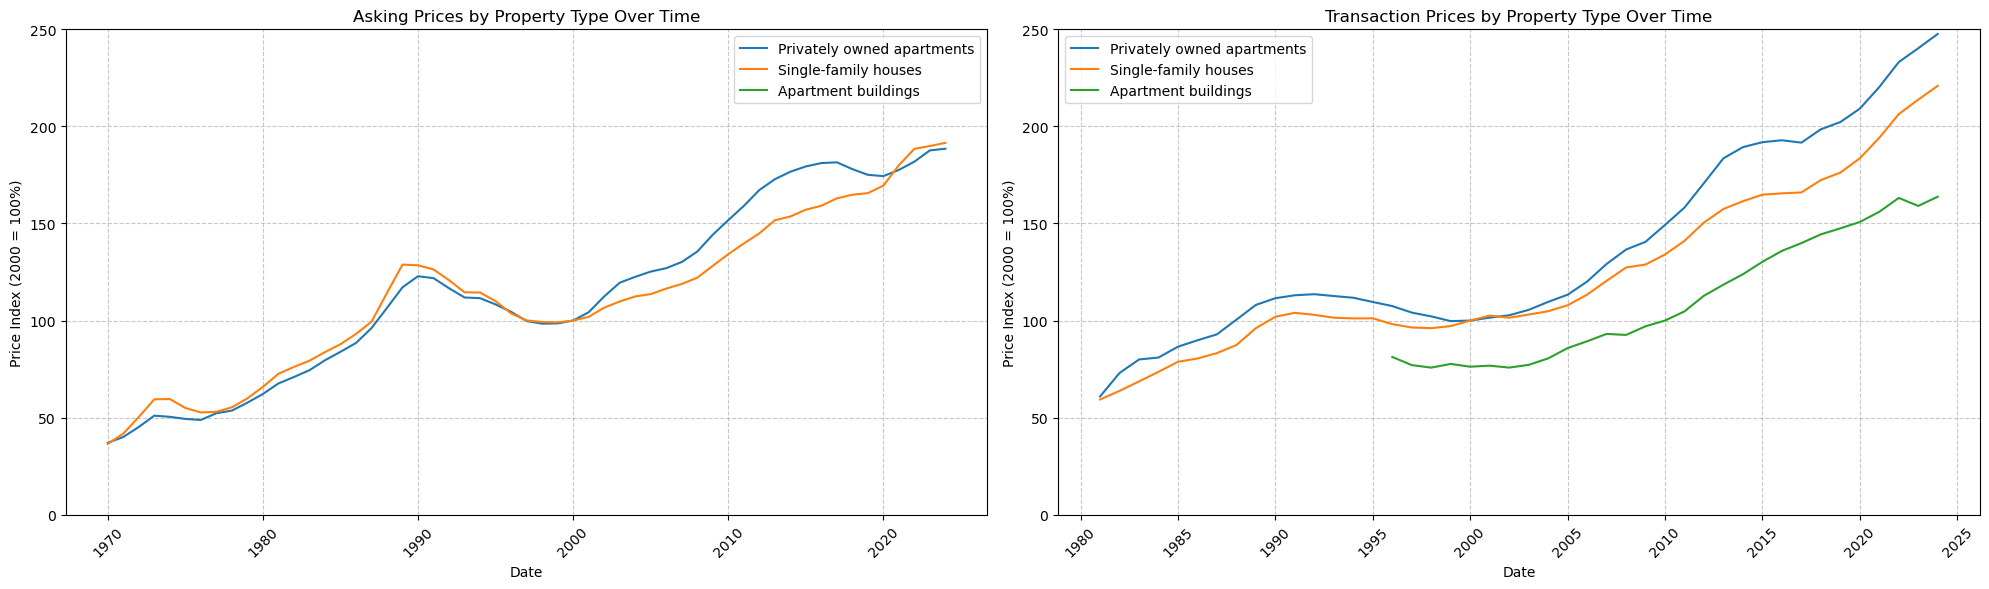

In [5]:
import matplotlib.pyplot as plt

# 1. Convert the 'date' column to datetime
housing_df['date'] = pd.to_datetime(housing_df['date'])

# 2. Define the three property types (make sure these match exactly!)
property_types = []
for types in housing_df['property_type'].unique():
    property_types.append(types)

# Create figure and axes for two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# First subplot - Asking Prices
for property_type in property_types:
    mask = housing_df['property_type'] == property_type
    data = housing_df[mask].sort_values('date')
    ax1.plot(data['date'], data['asking_price'], label=property_type)

# Customize first subplot
ax1.set_title('Asking Prices by Property Type Over Time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price Index (2000 = 100%)')
ax1.set_ylim(0,250)
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.tick_params(axis='x', rotation=45)

# Second subplot - Transaction Prices
for property_type in property_types:
    mask = housing_df['property_type'] == property_type
    data = housing_df[mask].sort_values('date')
    ax2.plot(data['date'], data['transaction_price'], label=property_type)

# Customize second subplot
ax2.set_title('Transaction Prices by Property Type Over Time')
ax2.set_xlabel('Date')
ax2.set_ylabel('Price Index (2000 = 100%)')
ax2.set_ylim(0,250)
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

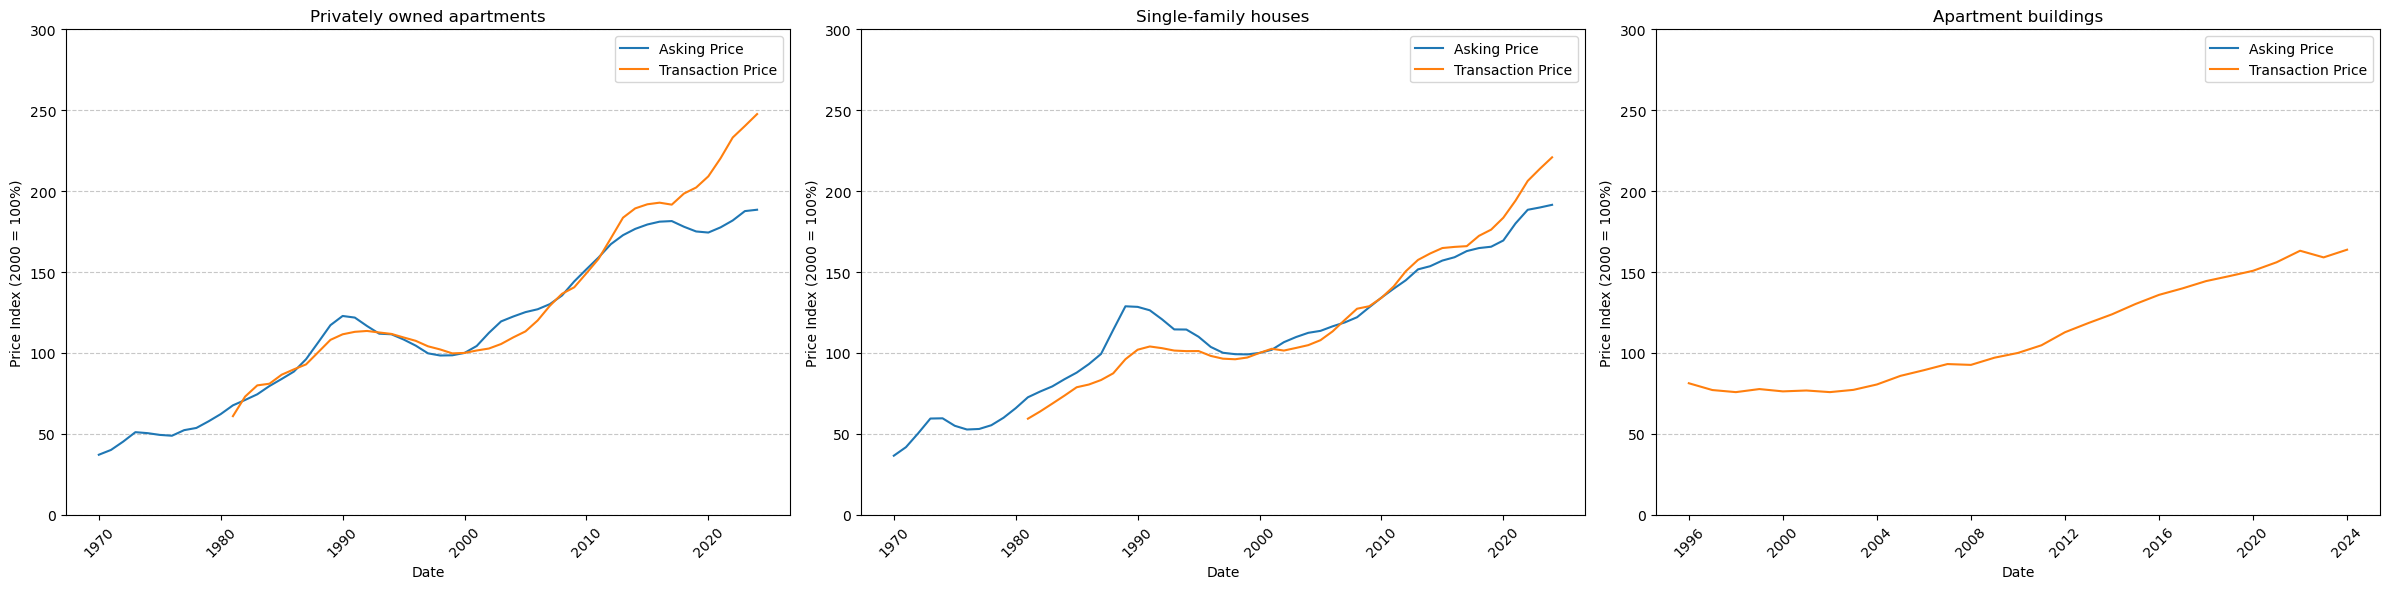

In [6]:
import matplotlib.pyplot as plt

# Create figure and axes for three subplots side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))

# Define the property types
property_types = []
for types in housing_df['property_type'].unique():
    property_types.append(types)

# Create a dictionary mapping axes to property types for cleaner code
ax_property_pairs = [
    (ax1, property_types[0]),
    (ax2, property_types[1]),
    (ax3, property_types[2])
]

# Plot each property type in its own subplot
for ax, property_type in ax_property_pairs:
    mask = housing_df['property_type'] == property_type
    data = housing_df[mask].sort_values('date')
    
    # Plot both asking and transaction prices
    ax.plot(data['date'], data['asking_price'], label='Asking Price')
    ax.plot(data['date'], data['transaction_price'], label='Transaction Price')
    
    # Customize subplot
    ax.set_title(f'{property_type}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price Index (2000 = 100%)')
    ax.set_ylim([0, 300])
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax.legend()
    ax.tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

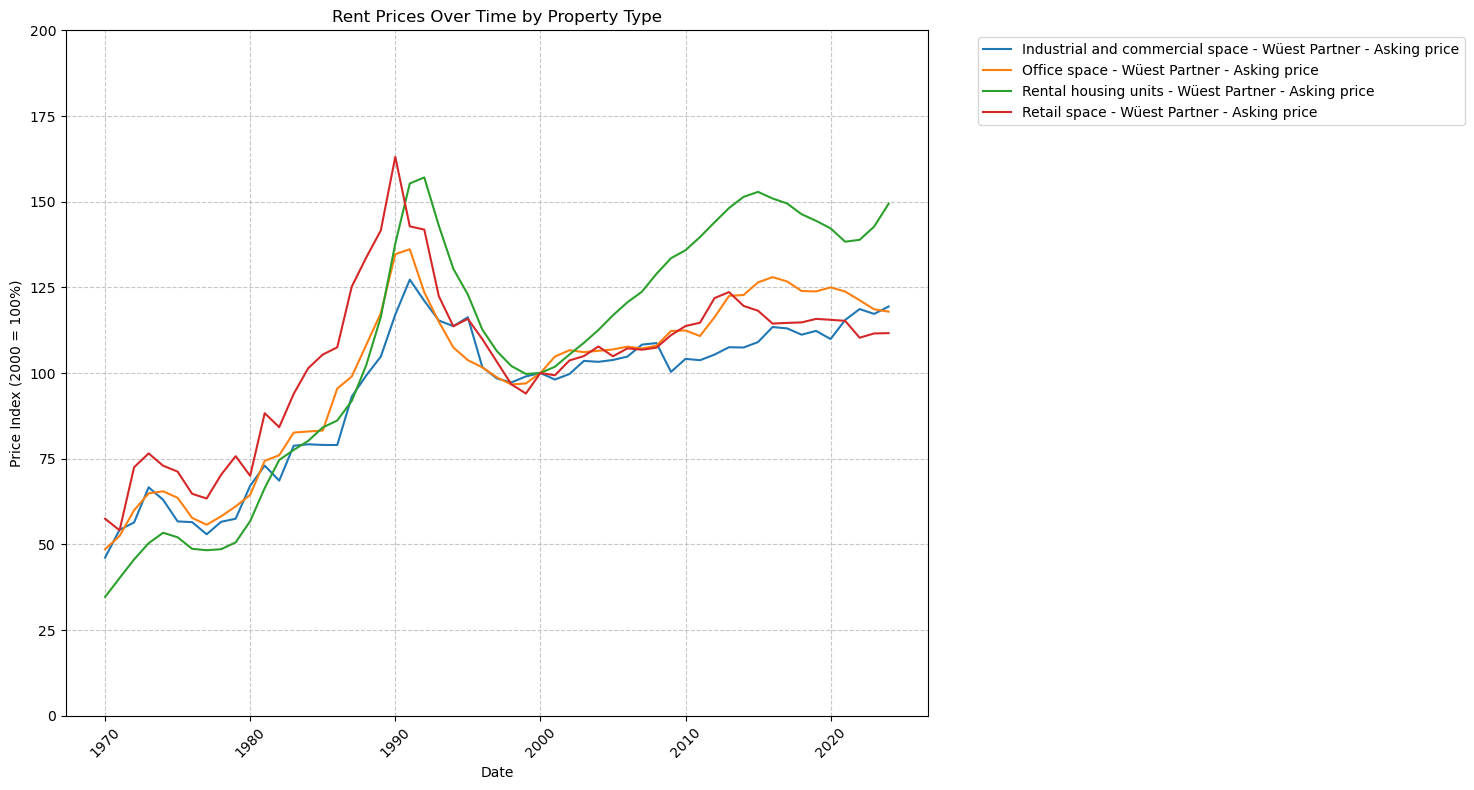

In [7]:
import matplotlib.pyplot as plt

rents_df = dfs['rents_df']

# Create figure and axis
plt.figure(figsize=(15, 8))

# Plot each rent type
rent_columns = []

for col in rents_df.columns:
    if col == 'date':
        continue
    rent_columns.append(col)

for column in rent_columns:
    plt.plot(rents_df['date'], rents_df[column], label=column.replace('Rents - ', ''))

# Customize plot
plt.title('Rent Prices Over Time by Property Type')
plt.xlabel('Date')
plt.ylabel('Price Index (2000 = 100%)')
plt.ylim([0, 200])
plt.yticks(range(0, 201, 25))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tick_params(axis='x', rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

In [8]:
averaged_df = dfs['averaged_df']
rents_df = dfs['rents_df']

statistics_df = pd.concat([averaged_df, rents_df])

statistics_df.describe()

date  \
count                            110   
mean   1996-12-31 14:50:10.909090944   
min              1970-01-01 00:00:00   
25%              1983-04-02 06:00:00   
50%              1997-01-01 00:00:00   
75%              2010-10-01 18:00:00   
max              2024-01-01 00:00:00   
std                              NaN   

       Privately owned apartments - Asking price  \
count                                  55.000000   
mean                                  114.179179   
min                                    37.067421   
25%                                    76.986206   
50%                                   111.889770   
75%                                   155.373856   
max                                   188.501891   
std                                    46.340399   

       Privately owned apartments - Transaction price  \
count                                       44.000000   
mean                                       136.271265   
min                                         60.920272   
25%                                        101.989638   
50%                                        112.836369   
75%                                        185.025848   
max                                        247.621496   
std                                         50.118778   

       Single-family houses - Asking price  \
count                            55.000000   
mean                            111.350553   
min                              36.476339   
25%                              81.523272   
50%                             112.424393   
75%                             136.926460   
max                             191.537261   
std                              40.936351   

       Single-family houses - Transaction price  \
count                                 44.000000   
mean                                 122.951590   
min                                   59.350776   
25%                                   96.984675   
50%                                  103.539813   
75%                                  158.481267   
max                                  220.900243   
std                                   42.094341   

       Apartment buildings (residential investment property) - Transaction price  \
count                                          29.000000                           
mean                                          110.578202                           
min                                            75.768477                           
25%                                            80.498467                           
50%                                           100.000000                           
75%                                           139.899647                           
max                                           163.797819                           
std                                            31.690167                           

       Rents - Industrial and commercial space - Wüest Partner - Asking price  \
count                                          55.000000                        
mean                                           94.437113                        
min                                            46.120740                        
25%                                            78.886086                        
50%                                           103.265784                        
75%                                           110.555780                        
max                                           127.254825                        
std                                            22.198375                        

       Rents - Office space - Wüest Partner - Asking price  \
count                                          55.000000     
mean                                           99.493931     
min                                            48.588164     
25%                                            82.780355     
50%             

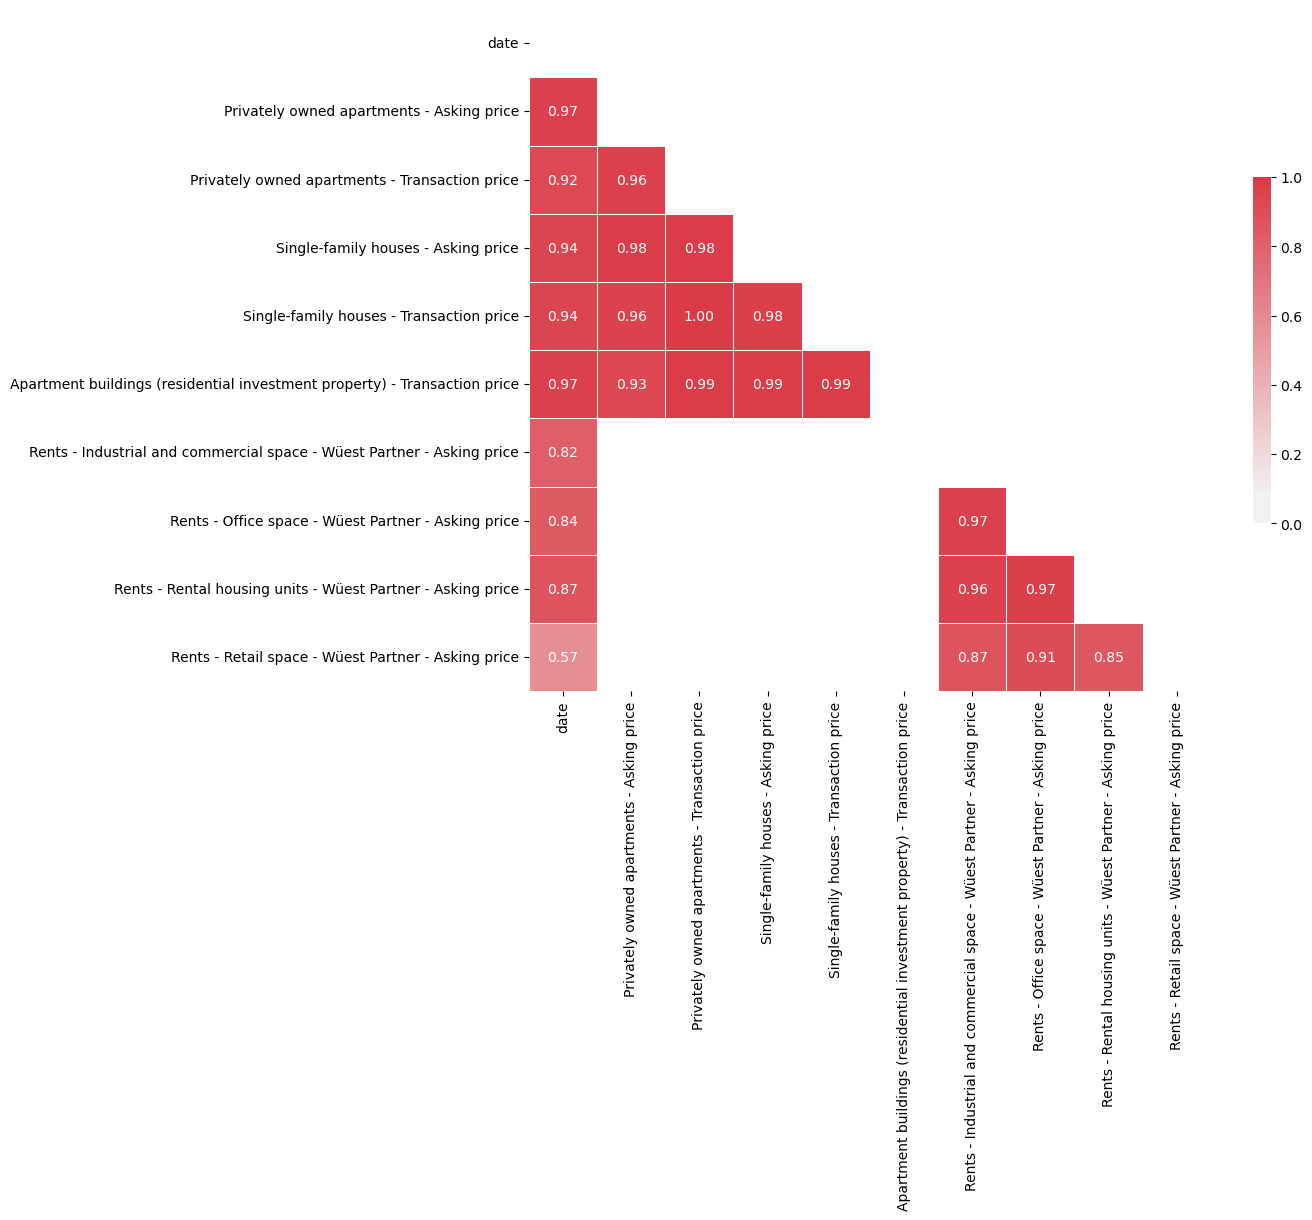

In [9]:
from visualization_function import plot_correlation_heatmap

# Use the function with the statistics dataframe
plot_correlation_heatmap(statistics_df, vmin=0)

# Importing Second Dataset:
Live births  
Deaths  
Natural Change  
Immigration  
Emigration  
Net migration  
Acquisition of Swiss citizenship

In [10]:
from data_processing import get_demographics_data

raw_demographics_df = get_demographics_data()
raw_demographics_df

ï»¿"YEAR" POPULATION_CHANGE_COMPONENT    VALUE OBS_STATUS
0          1861                        LIVB  74820.0          A
1          1862                        LIVB  75870.0          A
2          1863                        LIVB  79160.0          A
3          1864                        LIVB  79600.0          A
4          1865                        LIVB  78290.0          A
...         ...                         ...      ...        ...
1299       2019                     STATADJ   -238.0          A
1300       2020                     STATADJ    744.0          A
1301       2021                     STATADJ   1168.0          A
1302       2022                     STATADJ   -112.0          A
1303       2023                     STATADJ   -447.0          A

[1304 rows x 4 columns]

In [11]:
from data_processing import long_to_wide_demographics

demographics_df = long_to_wide_demographics(raw_demographics_df)
demographics_df

POPULATION_CHANGE_COMPONENT       date  Acquisition of Swiss citizenship  \
0                           1861-01-01                               NaN   
1                           1862-01-01                               NaN   
2                           1863-01-01                               NaN   
3                           1864-01-01                               NaN   
4                           1865-01-01                               NaN   
..                                 ...                               ...   
158                         2019-01-01                           41127.0   
159                         2020-01-01                           34141.0   
160                         2021-01-01                           36994.0   
161                         2022-01-01                           41486.0   
162                         2023-01-01                           41201.0   

POPULATION_CHANGE_COMPONENT   Deaths  Emigration  Immigration  Live births  \
0                            57520.0         NaN          NaN      74820.0   
1                            51070.0         NaN          NaN      75870.0   
2                            54360.0         NaN          NaN      79160.0   
3                            59500.0         NaN          NaN      79600.0   
4                            59090.0         NaN          NaN      78290.0   
..                               ...         ...          ...          ...   
158                          67780.0    126221.0     169573.0      86172.0   
159                          76195.0    109376.0     163180.0      85914.0   
160                          71192.0    116769.0     165640.0      89644.0   
161                          74425.0    122123.0     190883.0      82371.0   
162                          71822.0    123963.0     263081.0      80024.0   

POPULATION_CHANGE_COMPONENT  Natural Change  Net migration  \
0                                   17300.0          381.0   
1                                   24800.0        -3620.0   
2                                   24800.0        -3408.0   
3                                   20100.0        -1194.0   
4                                   19200.0        -2653.0   
..                                      ...            ...   
158                                 18392.0        43352.0   
159                                  9719.0        53804.0   
160                                 18452.0        48871.0   
161                                  7946.0        68760.0   
162                                  8202.0       139118.0   

POPULATION_CHANGE_COMPONENT  Statistical adjustments  
0                                                NaN  
1                                                NaN  
2                                                NaN  
3                                                NaN  
4                                                NaN  
..                                               ...  
158                                           -238.0  
159                                            744.0  
160                                           1168.0  
161                                           -112.0  
162                                           -447.0  

[163 rows x 9 columns]

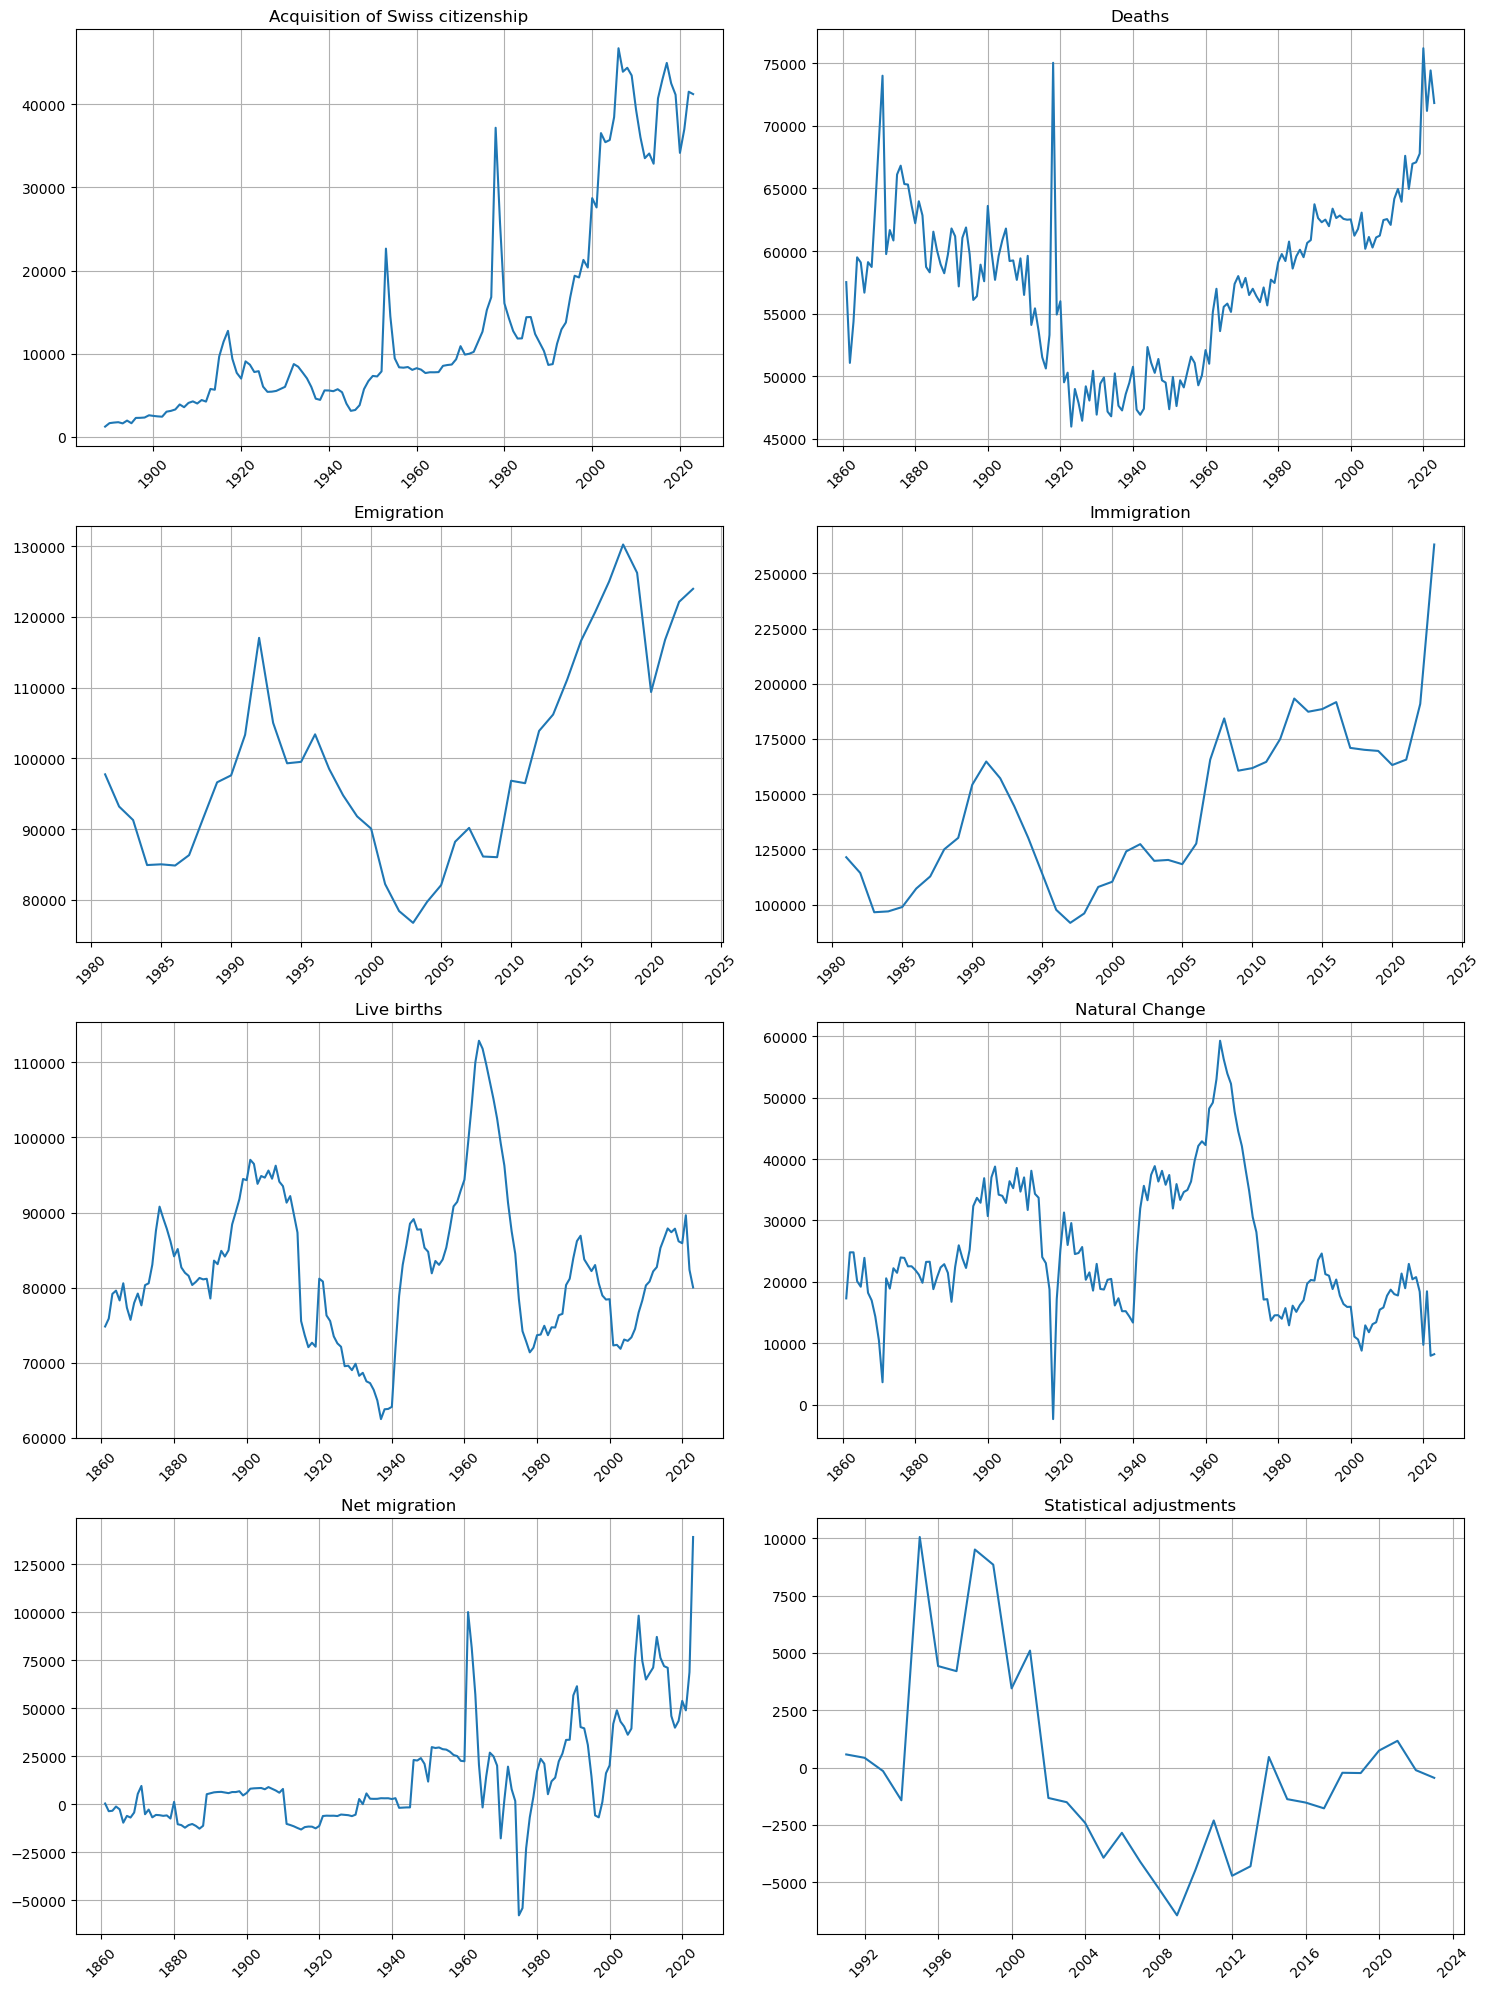

In [12]:
from visualization_function import plot_all_columns

plot_all_columns(demographics_df)

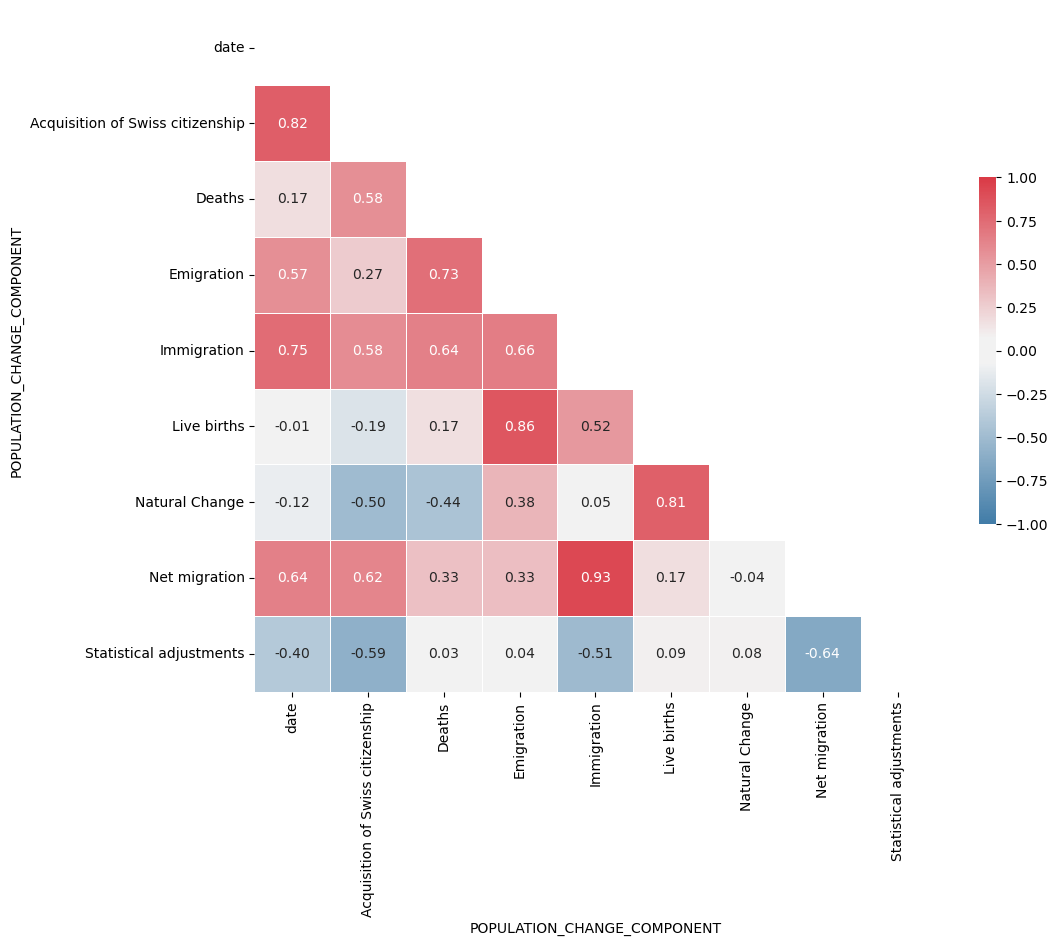

In [13]:
from visualization_function import plot_correlation_heatmap

plot_correlation_heatmap(demographics_df, vmin=-1)

# Importing Monetary Data

## Interest rates

In [14]:
from data_processing import get_and_process_snb_data

interest_rates_df = get_and_process_snb_data(url="https://data.snb.ch/api/cube/zimoma/data/json/en")
interest_rates_df

date  Switzerland - CHF - SARON - 1 day  \
0   1972-01-01                                NaN   
1   1972-02-01                                NaN   
2   1972-03-01                                NaN   
3   1972-04-01                                NaN   
4   1972-05-01                                NaN   
..         ...                                ...   
632 2024-09-01                           0.957401   
633 2024-10-01                           0.949059   
634 2024-11-01                           0.942743   
635 2024-12-01                           0.451195   
636 2025-01-01                           0.430306   

     Switzerland - CHF - Call money rate (Tomorrow next) - 1 day  \
0                                                0.000             
1                                                0.000             
2                                                0.125             
3                                                0.250             
4                                                1.500             
..                                                 ...             
632                                              0.640             
633                                              0.850             
634                                              0.730             
635                                              0.160             
636                                              0.230             

     Switzerland - CHF - Money market debt register claims of the Swiss Confederation - 3-month  \
0                                                  NaN                                            
1                                                  NaN                                            
2                                                  NaN                                            
3                                                  NaN                                            
4                                                  NaN                                            
..                                                 ...                                            
632                                              0.840                                            
633                                              0.678                                            
634                                              0.559                                            
635                                              0.352                                            
636                                              0.157                                            

     Switzerland - CHF - CHF LIBOR - 3-month  \
0                                        NaN   
1                                        NaN   
2                                        NaN   
3                                        NaN   
4                                        NaN   
..                                       ...   
632                                      NaN   
633                                      NaN   
634                                      NaN   
635                                      NaN   
636                                      NaN   

     United States - USD - SOFR - 1-day  \
0                                   NaN   
1                                   NaN   
2                                   NaN   
3                                   NaN   
4                                   NaN   
..                                  ...   
632                                4.96   
633                                4.90   
634                                4.59   
635                                4.49   
636                                 NaN   

     United States - USD - USD LIBOR - 3-month  Japan - JPY - TONA - 1-day  \
0                                          NaN                         NaN   
1                                          NaN                         NaN   
2                                      

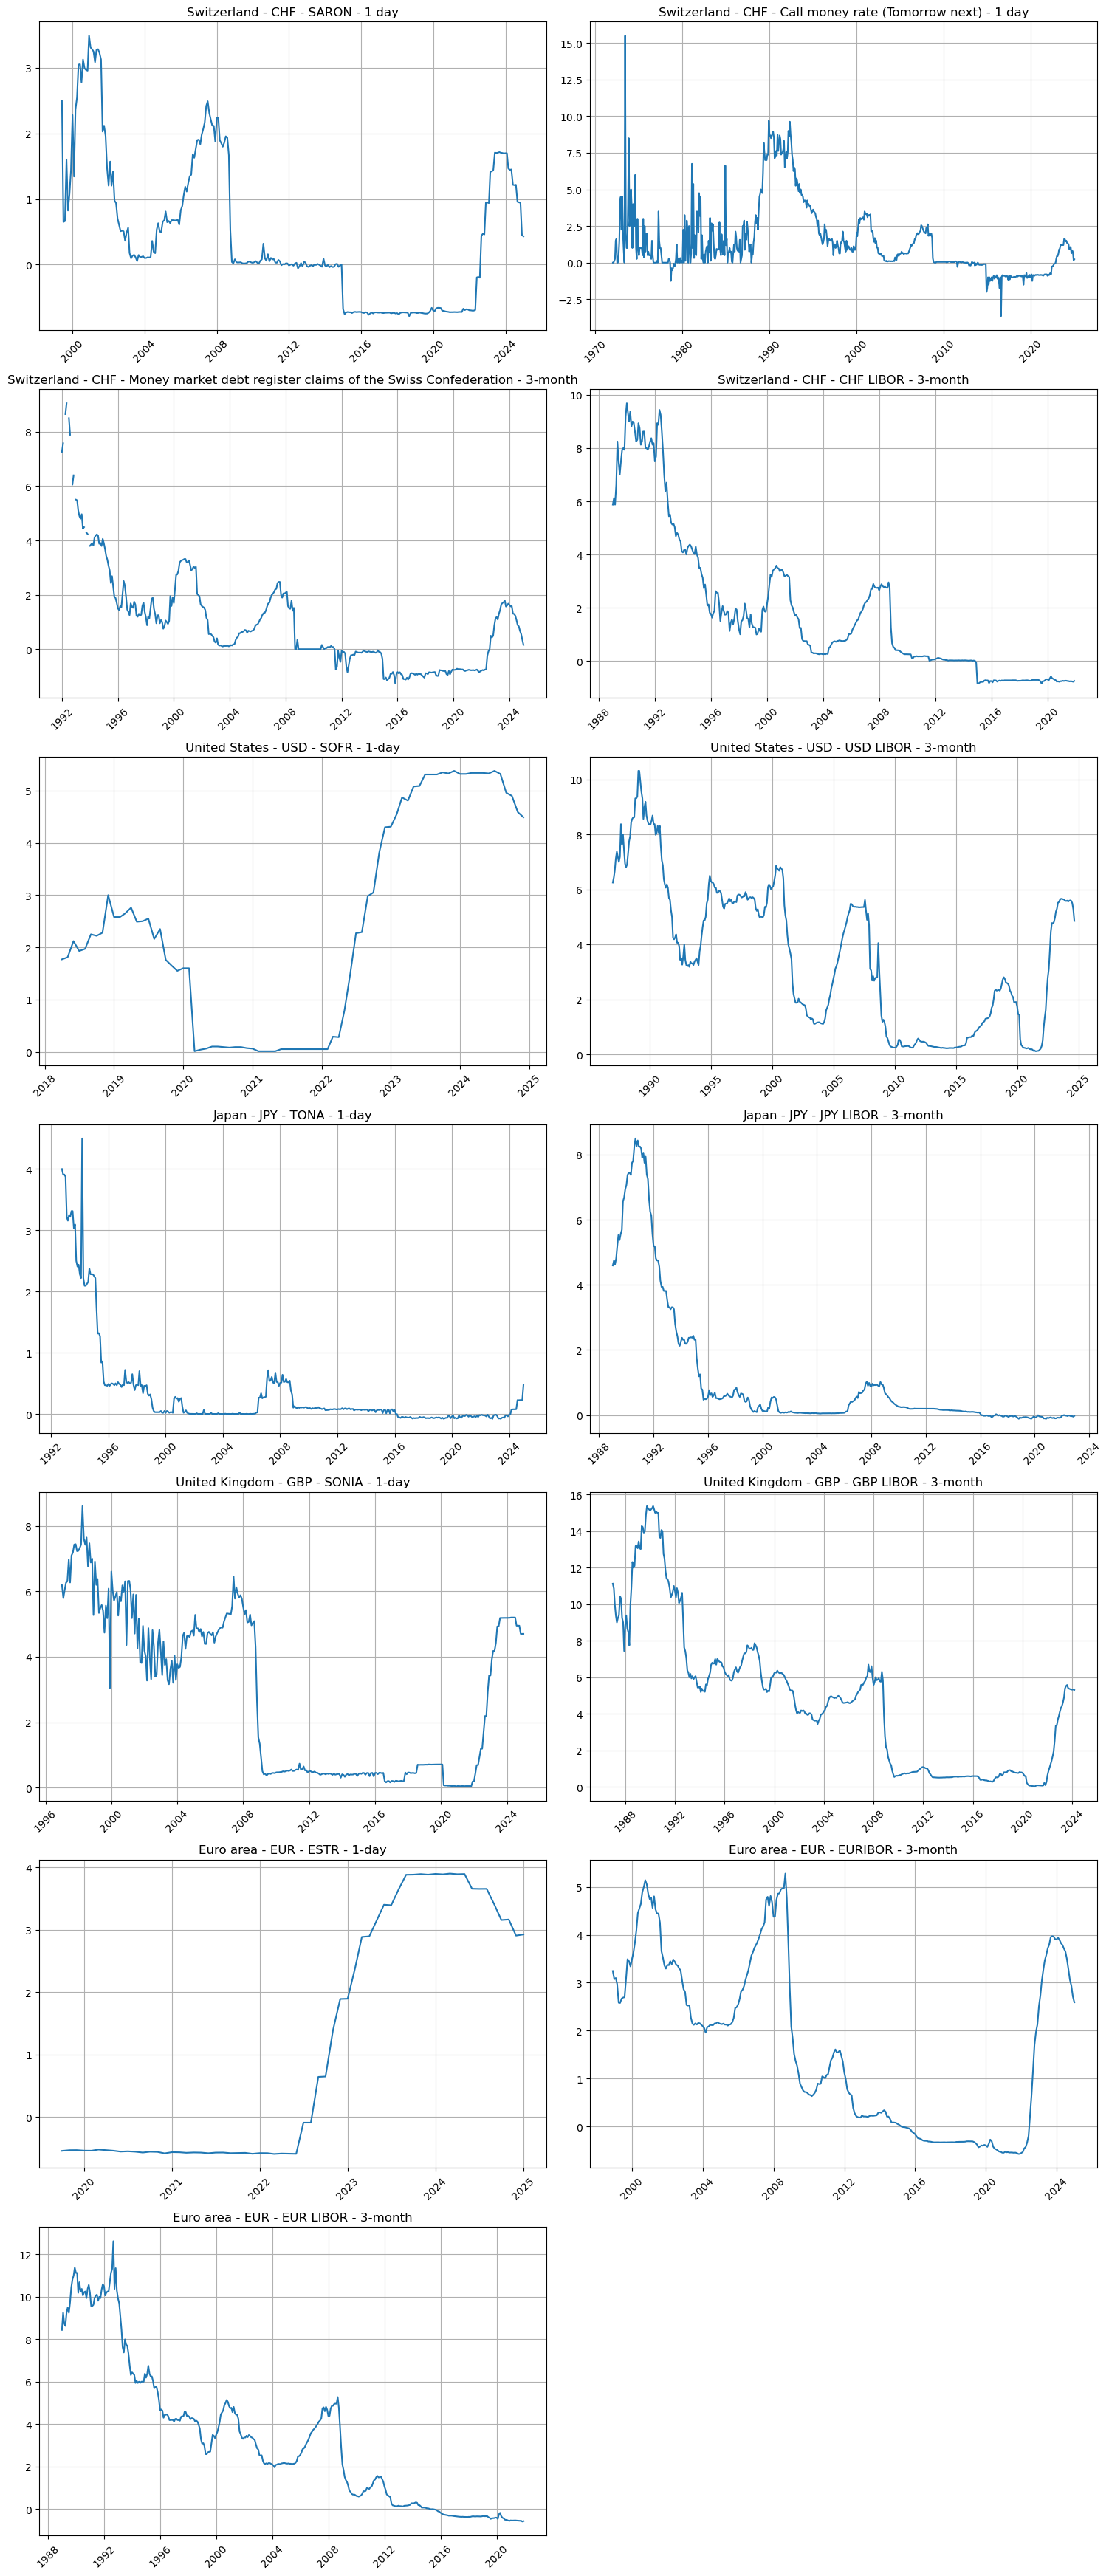

In [15]:
from visualization_function import plot_all_columns

plot_all_columns(interest_rates_df)

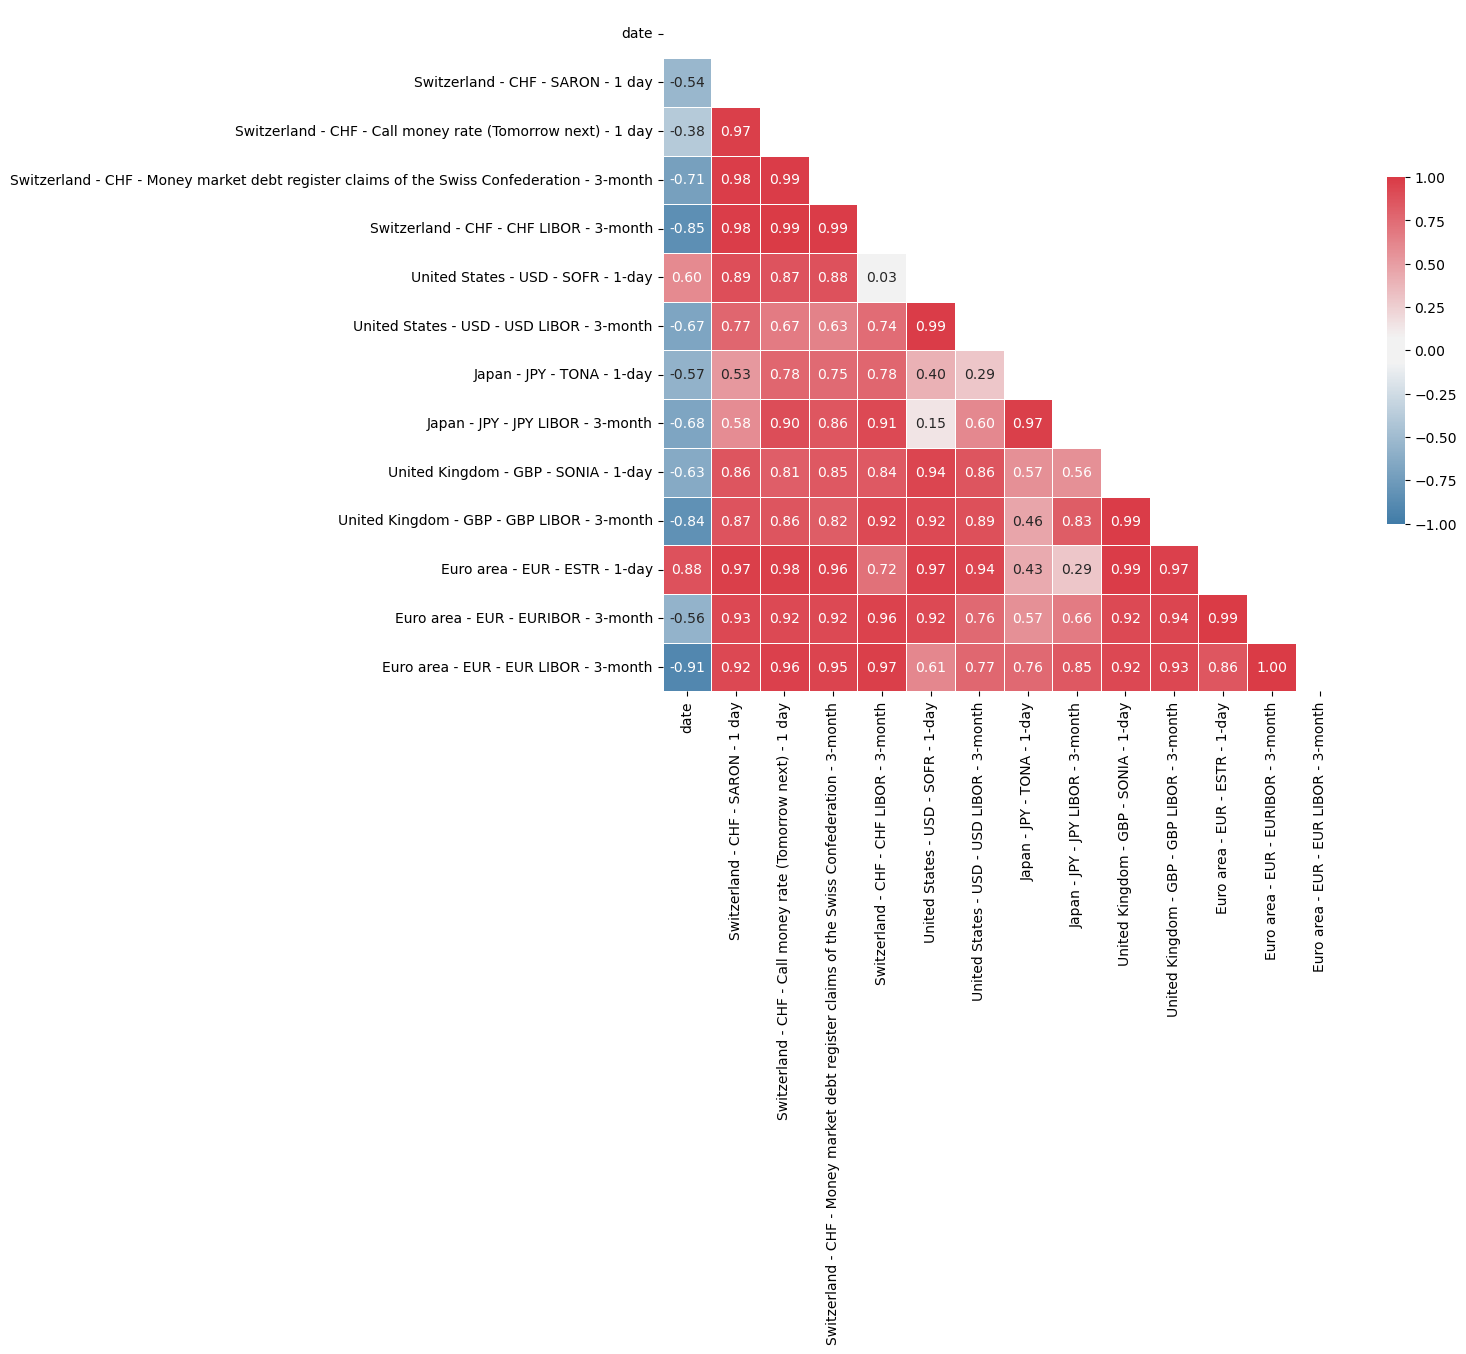

In [16]:
from visualization_function import plot_correlation_heatmap

plot_correlation_heatmap(interest_rates_df)

In [17]:
from data_processing import group_data_by_year

yearly_interest_rates_df=group_data_by_year(interest_rates_df)
yearly_interest_rates_df

date  Switzerland - CHF - SARON - 1 day  \
0  1972-01-01                                NaN   
1  1973-01-01                                NaN   
2  1974-01-01                                NaN   
3  1975-01-01                                NaN   
4  1976-01-01                                NaN   
5  1977-01-01                                NaN   
6  1978-01-01                                NaN   
7  1979-01-01                                NaN   
8  1980-01-01                                NaN   
9  1981-01-01                                NaN   
10 1982-01-01                                NaN   
11 1983-01-01                                NaN   
12 1984-01-01                                NaN   
13 1985-01-01                                NaN   
14 1986-01-01                                NaN   
15 1987-01-01                                NaN   
16 1988-01-01                                NaN   
17 1989-01-01                                NaN   
18 1990-01-01                                NaN   
19 1991-01-01                                NaN   
20 1992-01-01                                NaN   
21 1993-01-01                                NaN   
22 1994-01-01                                NaN   
23 1995-01-01                                NaN   
24 1996-01-01                                NaN   
25 1997-01-01                                NaN   
26 1998-01-01                                NaN   
27 1999-01-01                            1.25086   
28 2000-01-01                            2.74534   
29 2001-01-01                            2.78423   
30 2002-01-01                            0.87583   
31 2003-01-01                            0.18932   
32 2004-01-01                            0.28546   
33 2005-01-01                            0.67329   
34 2006-01-01                            1.33429   
35 2007-01-01                            2.12445   
36 2008-01-01                            1.50182   
37 2009-01-01                            0.03475   
38 2010-01-01                            0.08165   
39 2011-01-01                            0.04032   
40 2012-01-01                            0.00055   
41 2013-01-01                           -0.00547   
42 2014-01-01                           -0.01683   
43 2015-01-01                           -0.72435   
44 2016-01-01                           -0.73562   
45 2017-01-01                           -0.73627   
46 2018-01-01                           -0.73963   
47 2019-01-01                           -0.72954   
48 2020-01-01                           -0.69546   
49 2021-01-01                           -0.71031   
50 2022-01-01                           -0.14723   
51 2023-01-01                            1.50792   
52 2024-01-01                            1.22494   
53 2025-01-01                            0.43031   

    Switzerland - CHF - Call money rate (Tomorrow next) - 1 day  \
0                                             1.18750             
1                                             3.67708             
2                                             2.91667             
3                                             1.30208             
4                                             0.41667             
5                                             0.63542             
6                                            -0.16667             
7                                             0.14583             
8                                             1.30208             
9                                             2.54688             
10                                            1.12500             
11                                            1.35938             
12                                            1.56771             
13                                            0.72396             
14                                            1.08333             
15                                            1.64062             
16       

## Monetary base

In [18]:
from data_processing import get_and_process_snb_data

monthly_monetary_base_df = get_and_process_snb_data(url="https://data.snb.ch/api/cube/snbmoba/data/json/en")
monthly_monetary_base_df

date  Origination - Relevant foreign currency positions  \
0   1950-01-01                                                NaN   
1   1950-02-01                                                NaN   
2   1950-03-01                                                NaN   
3   1950-04-01                                                NaN   
4   1950-05-01                                                NaN   
..         ...                                                ...   
896 2024-09-01                                           803049.0   
897 2024-10-01                                           830422.0   
898 2024-11-01                                           834166.0   
899 2024-12-01                                           844365.0   
900 2025-01-01                                                NaN   

     Origination - Securities portfolio  \
0                                   NaN   
1                                   NaN   
2                                   NaN   
3                                   NaN   
4                                   NaN   
..                                  ...   
896                              3876.0   
897                              3938.0   
898                              3942.0   
899                              3958.0   
900                                 NaN   

     Origination - Money market transactions  Origination - Other  \
0                                        NaN                  NaN   
1                                        NaN                  NaN   
2                                        NaN                  NaN   
3                                        NaN                  NaN   
4                                        NaN                  NaN   
..                                       ...                  ...   
896                                      0.0             277795.0   
897                                      0.0             308632.0   
898                                      0.0             313152.0   
899                                      0.0             331378.0   
900                                      NaN                  NaN   

     Origination - Monetary base  Utilisation - Banknotes in circulation  \
0                         5824.0                                  4295.0   
1                         5698.0                                  4161.0   
2                         5747.0                                  4191.0   
3                         5660.0                                  4189.0   
4                         5647.0                                  4182.0   
..                           ...                                     ...   
896                     529130.0                                 72049.0   
897                     525728.0                                 71941.0   
898                     524956.0                                 72013.0   
899                     516945.0                                 73173.0   
900                     508558.0                                 73352.0   

     Utilisation - Sight deposit accounts of domestic banks  \
0                                               1529.0        
1                                               1537.0        
2                                               1556.0        
3                                               1471.0        
4                                               1465.0        
..                                                 ...        
896                                           457081.0        
897                                           453787.0        
898                                           452943.0        
899                                           443772.0        
900                                           435206.0        

     Utilisation - Monetary base  Seasonally adjusted - Monetary base  \
0                         5824.0                                  NaN   
1                  

In [19]:
from data_processing import group_data_by_year

yearly_monetary_base_df = group_data_by_year(monthly_monetary_base_df)
yearly_monetary_base_df

date  Origination - Relevant foreign currency positions  \
0  1950-01-01                                                NaN   
1  1951-01-01                                                NaN   
2  1952-01-01                                                NaN   
3  1953-01-01                                                NaN   
4  1954-01-01                                                NaN   
..        ...                                                ...   
71 2021-01-01                                       1.009690e+06   
72 2022-01-01                                       9.719643e+05   
73 2023-01-01                                       8.063621e+05   
74 2024-01-01                                       8.100418e+05   
75 2025-01-01                                                NaN   

    Origination - Securities portfolio  \
0                                  NaN   
1                                  NaN   
2                                  NaN   
3                                  NaN   
4                                  NaN   
..                                 ...   
71                          4001.75000   
72                          3740.91667   
73                          3638.75000   
74                          3876.08333   
75                                 NaN   

    Origination - Money market transactions  Origination - Other  \
0                                       NaN                  NaN   
1                                       NaN                  NaN   
2                                       NaN                  NaN   
3                                       NaN                  NaN   
4                                       NaN                  NaN   
..                                      ...                  ...   
71                                110.75000         288184.58333   
72                               8215.00000         277096.91667   
73                                144.91667         246689.33333   
74                                  0.00000         284594.75000   
75                                      NaN                  NaN   

    Origination - Monetary base  Utilisation - Banknotes in circulation  \
0                    5753.16667                              4239.58333   
1                    5692.66667                              4419.58333   
2                    5775.91667                              4595.08333   
3                    6164.58333                              4780.75000   
4                    6261.58333                              4902.33333   
..                          ...                                     ...   
71                 725618.25000                             88283.91667   
72                 706823.33333                             87182.41667   
73                 563456.41667                             76504.58333   
74                 529323.16667                             73261.58333   
75                 508558.00000                             73352.00000   

    Utilisation - Sight deposit accounts of domestic banks  \
0                                          1513.58333        
1                                          1273.08333        
2                                          1180.83333        
3                                          1383.83333        
4                                          1359.25000        
..                                                ...        
71                                       637334.33333        
72                                       619640.91667        
73                                       486951.83333        
74                                       456061.58333        
75                                       435206.00000        

    Utilisation - Monetary base  Seasonally adjusted - Monetary base  \
0                    5753.16667                                  NaN   
1                    5692.66667                                  NaN   
2       

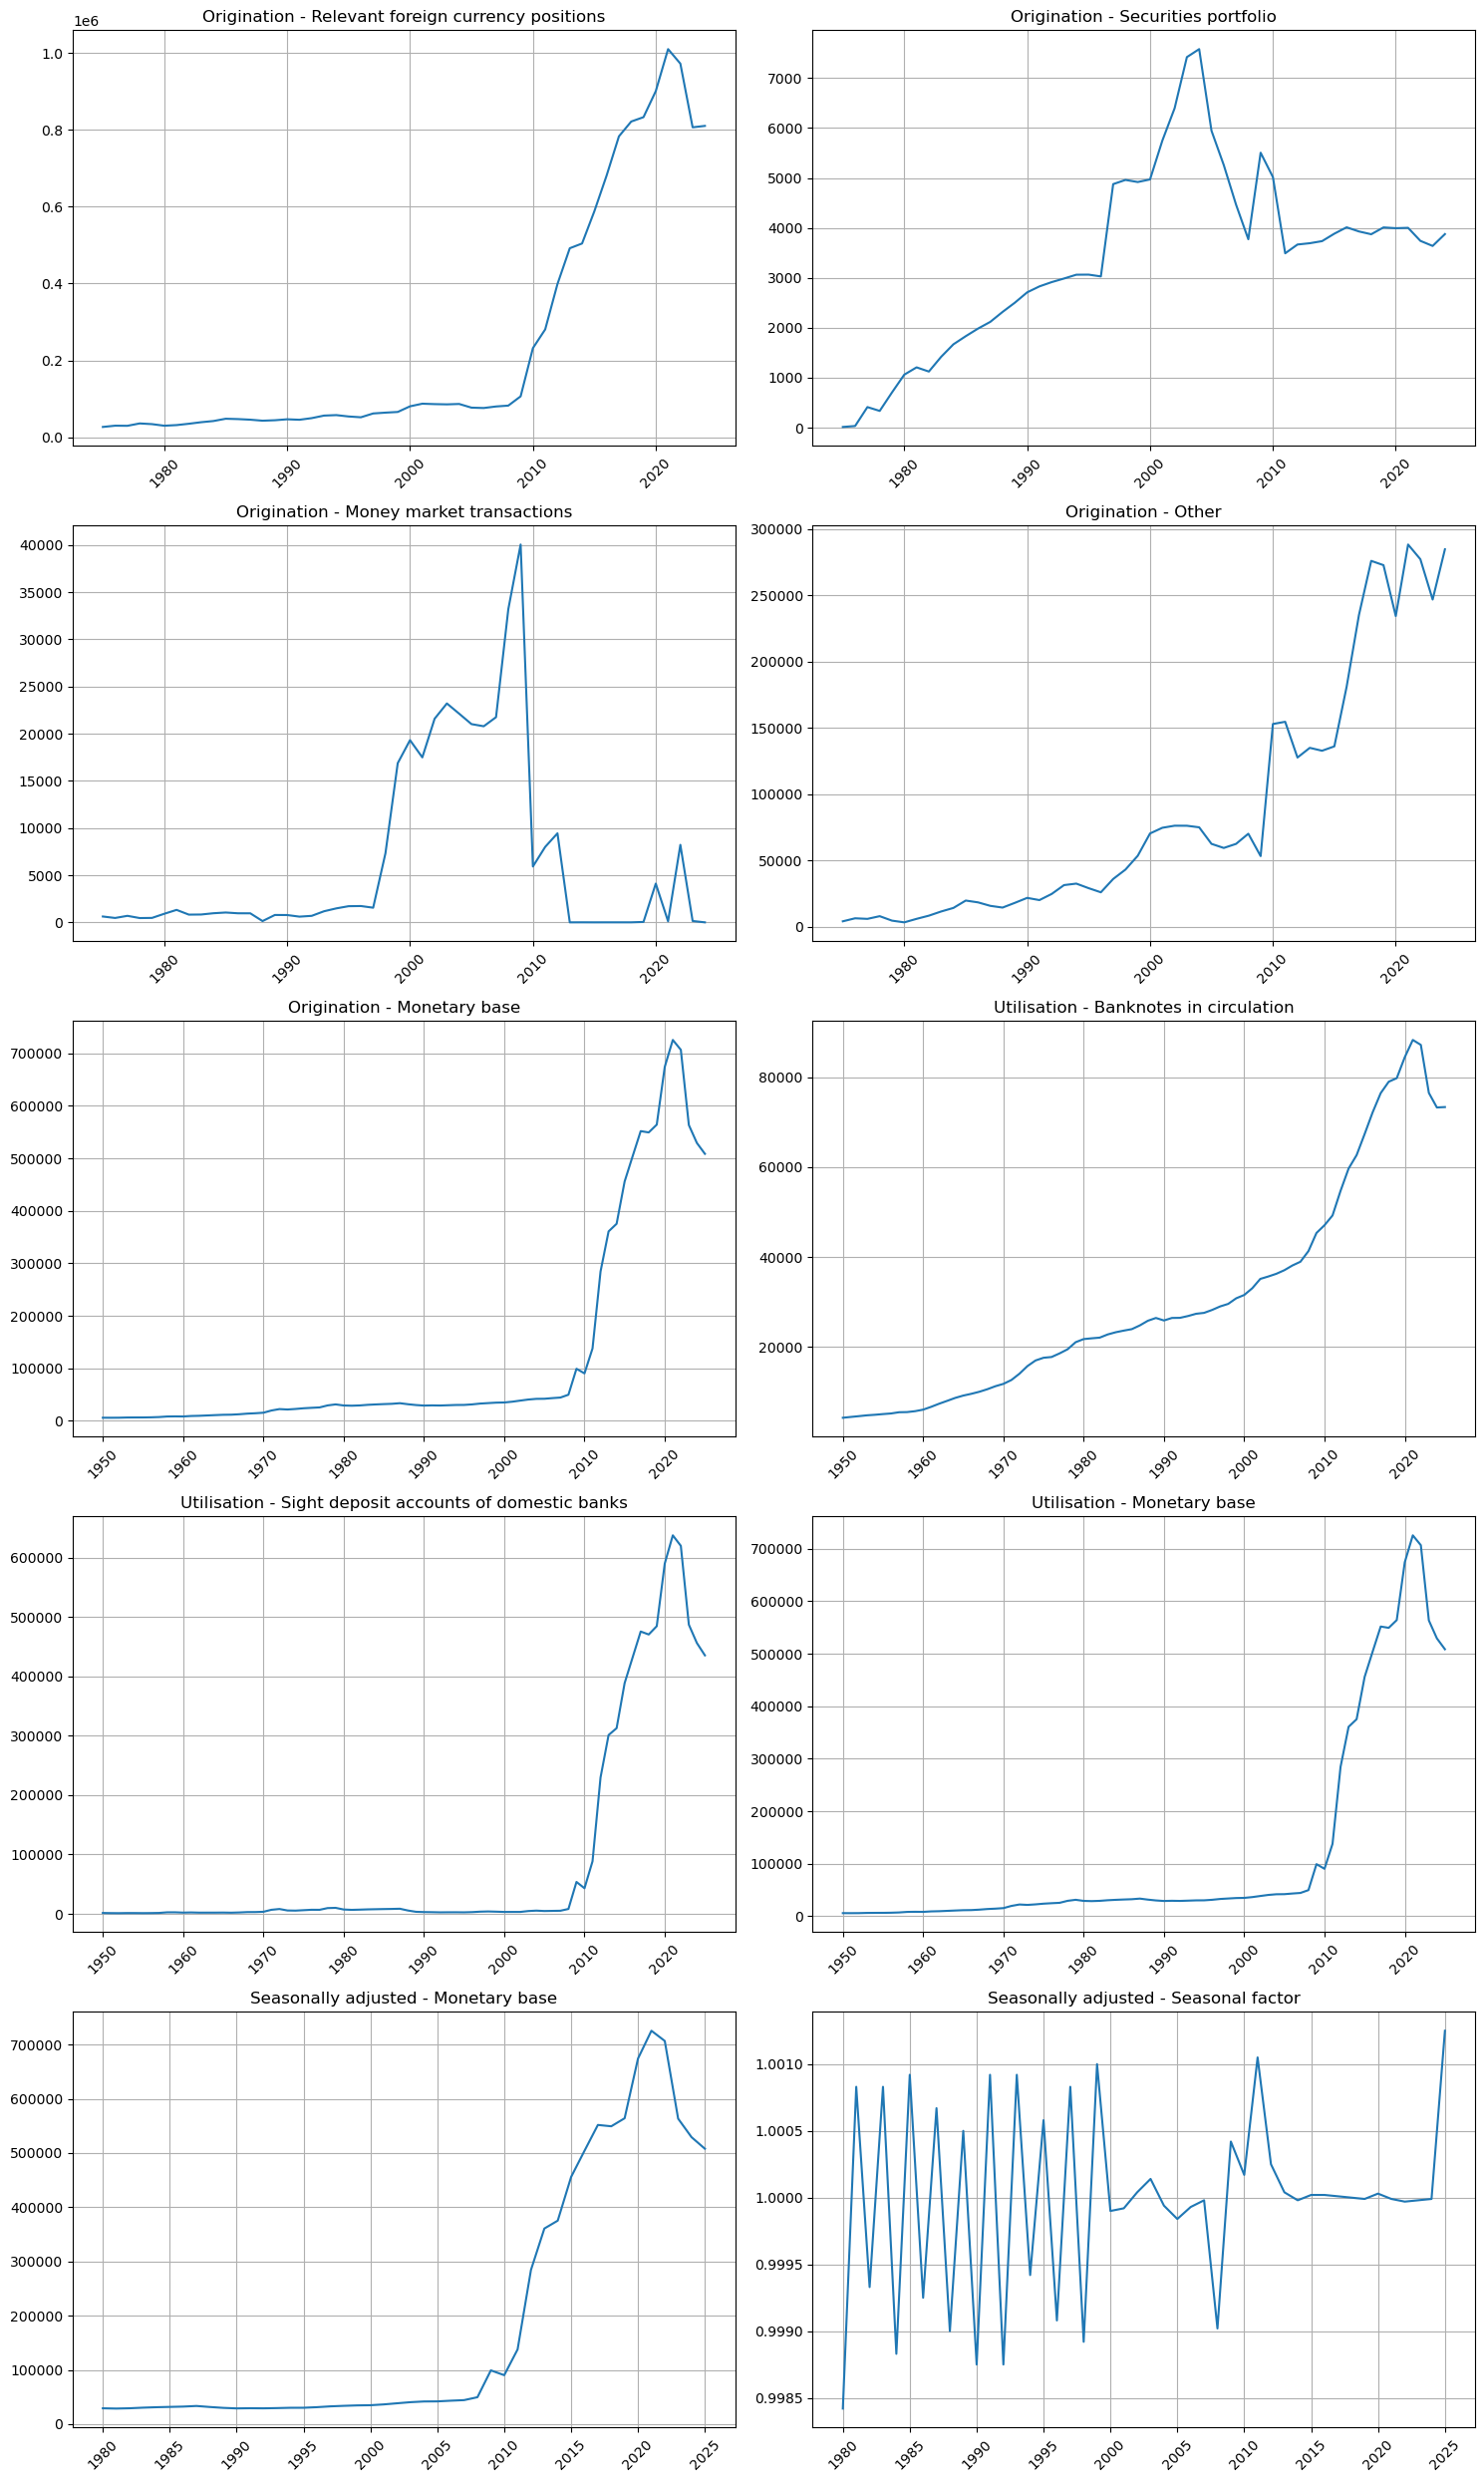

In [20]:
from visualization_function import plot_all_columns

plot_all_columns(yearly_monetary_base_df)

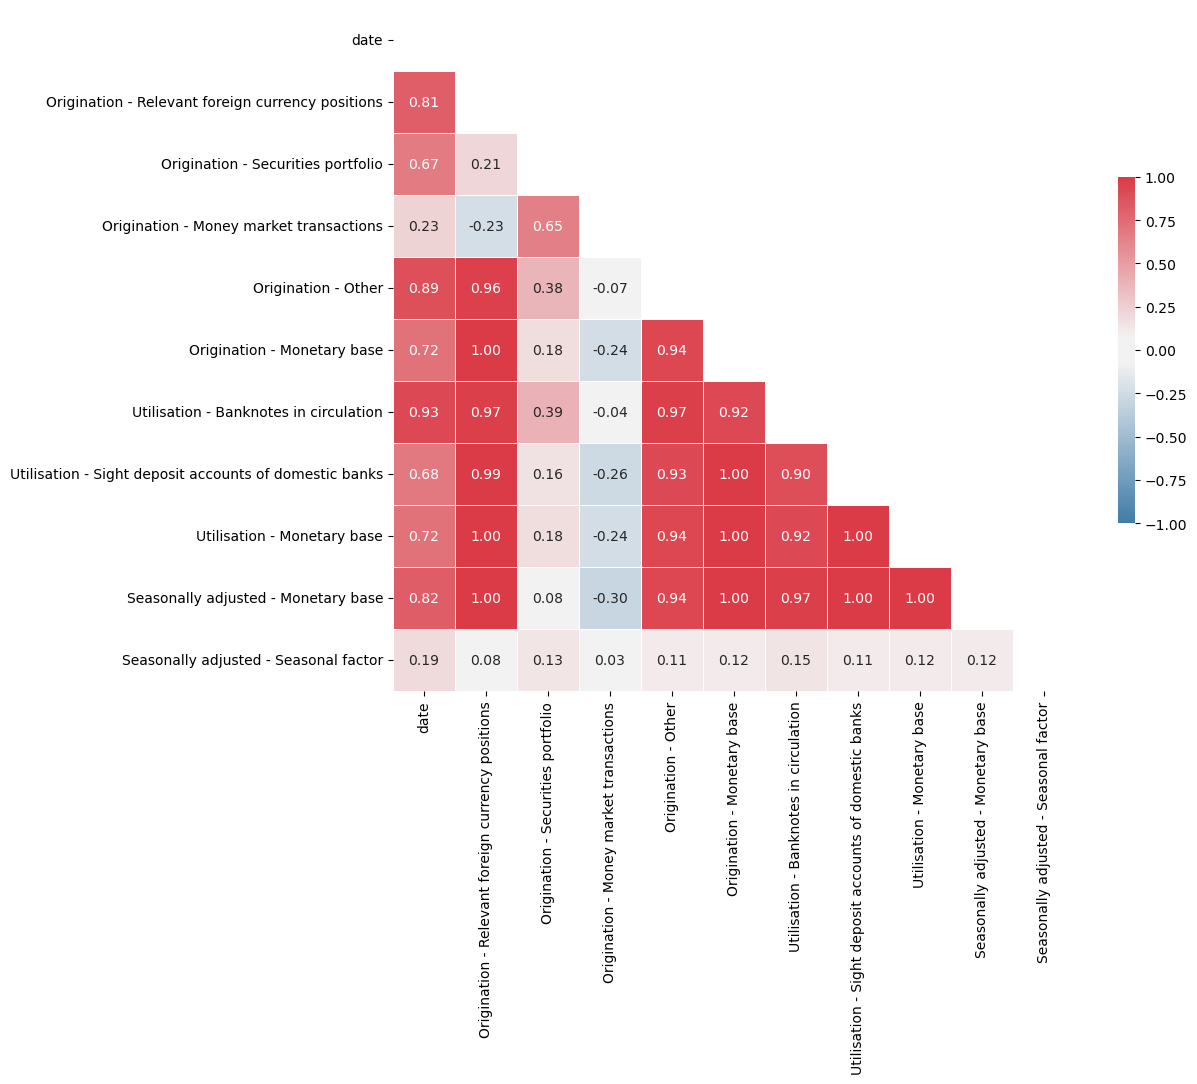

In [21]:
from visualization_function import plot_correlation_heatmap

plot_correlation_heatmap(yearly_monetary_base_df)

## Monetary aggregates M1, M2 and M3

In [22]:
from data_processing import get_and_process_snb_data_two_header_levels

monthly_monetary_aggregate_df = get_and_process_snb_data_two_header_levels(url="https://data.snb.ch/api/cube/snbmonagg/data/json/en")
monthly_monetary_aggregate_df


column_name       date  \
0           1984-12-01   
1           1985-01-01   
2           1985-02-01   
3           1985-03-01   
4           1985-04-01   
..                 ...   
477         2024-09-01   
478         2024-10-01   
479         2024-11-01   
480         2024-12-01   
481         2025-01-01   

column_name  Change from the corresponding month of the previous year - Currency in circulation  \
0                                                          NaN                                    
1                                                          NaN                                    
2                                                          NaN                                    
3                                                          NaN                                    
4                                                          NaN                                    
..                                                         ...                                    
477                                                  -3.005002                                    
478                                                  -2.637668                                    
479                                                  -2.388011                                    
480                                                  -1.972041                                    
481                                                  -1.594219                                    

column_name  Change from the corresponding month of the previous year - Deposits in transaction accounts  \
0                                                          NaN                                             
1                                                          NaN                                             
2                                                          NaN                                             
3                                                          NaN                                             
4                                                          NaN                                             
..                                                         ...                                             
477                                                  -6.413741                                             
478                                                  -3.530587                                             
479                                                  -1.462715                                             
480                                                  -1.286298                                             
481                                                   7.499710                                             

column_name  Change from the corresponding month of the previous year - Monetary aggregate M1  \
0                                                          NaN                                  
1                                                          NaN                                  
2                                                          NaN                                  
3                                                          NaN                                  
4                                                          NaN                                  
..                                                         ...                                  
477                                                  -4.022466                                  
478                                                  -2.978578                                  
479                                                  -1.120332                                  
480                                                   2.367945                                  
481                                                   4.063194                                  

column_name  Change from the corresp

In [23]:
from data_processing import group_data_by_year

yearly_monetary_aggregate_df = group_data_by_year(monthly_monetary_aggregate_df)
yearly_monetary_aggregate_df

column_name       date  \
0           1984-01-01   
1           1985-01-01   
2           1986-01-01   
3           1987-01-01   
4           1988-01-01   
5           1989-01-01   
6           1990-01-01   
7           1991-01-01   
8           1992-01-01   
9           1993-01-01   
10          1994-01-01   
11          1995-01-01   
12          1996-01-01   
13          1997-01-01   
14          1998-01-01   
15          1999-01-01   
16          2000-01-01   
17          2001-01-01   
18          2002-01-01   
19          2003-01-01   
20          2004-01-01   
21          2005-01-01   
22          2006-01-01   
23          2007-01-01   
24          2008-01-01   
25          2009-01-01   
26          2010-01-01   
27          2011-01-01   
28          2012-01-01   
29          2013-01-01   
30          2014-01-01   
31          2015-01-01   
32          2016-01-01   
33          2017-01-01   
34          2018-01-01   
35          2019-01-01   
36          2020-01-01   
37          2021-01-01   
38          2022-01-01   
39          2023-01-01   
40          2024-01-01   
41          2025-01-01   

column_name  Change from the corresponding month of the previous year - Currency in circulation  \
0                                                          NaN                                    
1                                                     -1.97482                                    
2                                                      1.22039                                    
3                                                      2.68659                                    
4                                                      4.99140                                    
5                                                      2.29459                                    
6                                                     -1.93539                                    
7                                                      2.67302                                    
8                                                      0.34154                                    
9                                                      1.65185                                    
10                                                     1.73665                                    
11                                                     0.90761                                    
12                                                     2.60746                                    
13                                                     3.29040                                    
14                                                     1.42198                                    
15                                                     3.39807                                    
16                                                     2.38063                                    
17                                                     5.09013                                    
18                                                     5.52498                                    
19                                                     1.29236                                    
20                                                     1.44642                                    
21                                                     2.13874                                    
22                                                     2.39990                                    
23                                                     2.04908                                    
24                                                     4.25968                                    
25                                                    11.38278                                    
26                                                     4.94931                                    
27                                                     7.52666                                    
28        

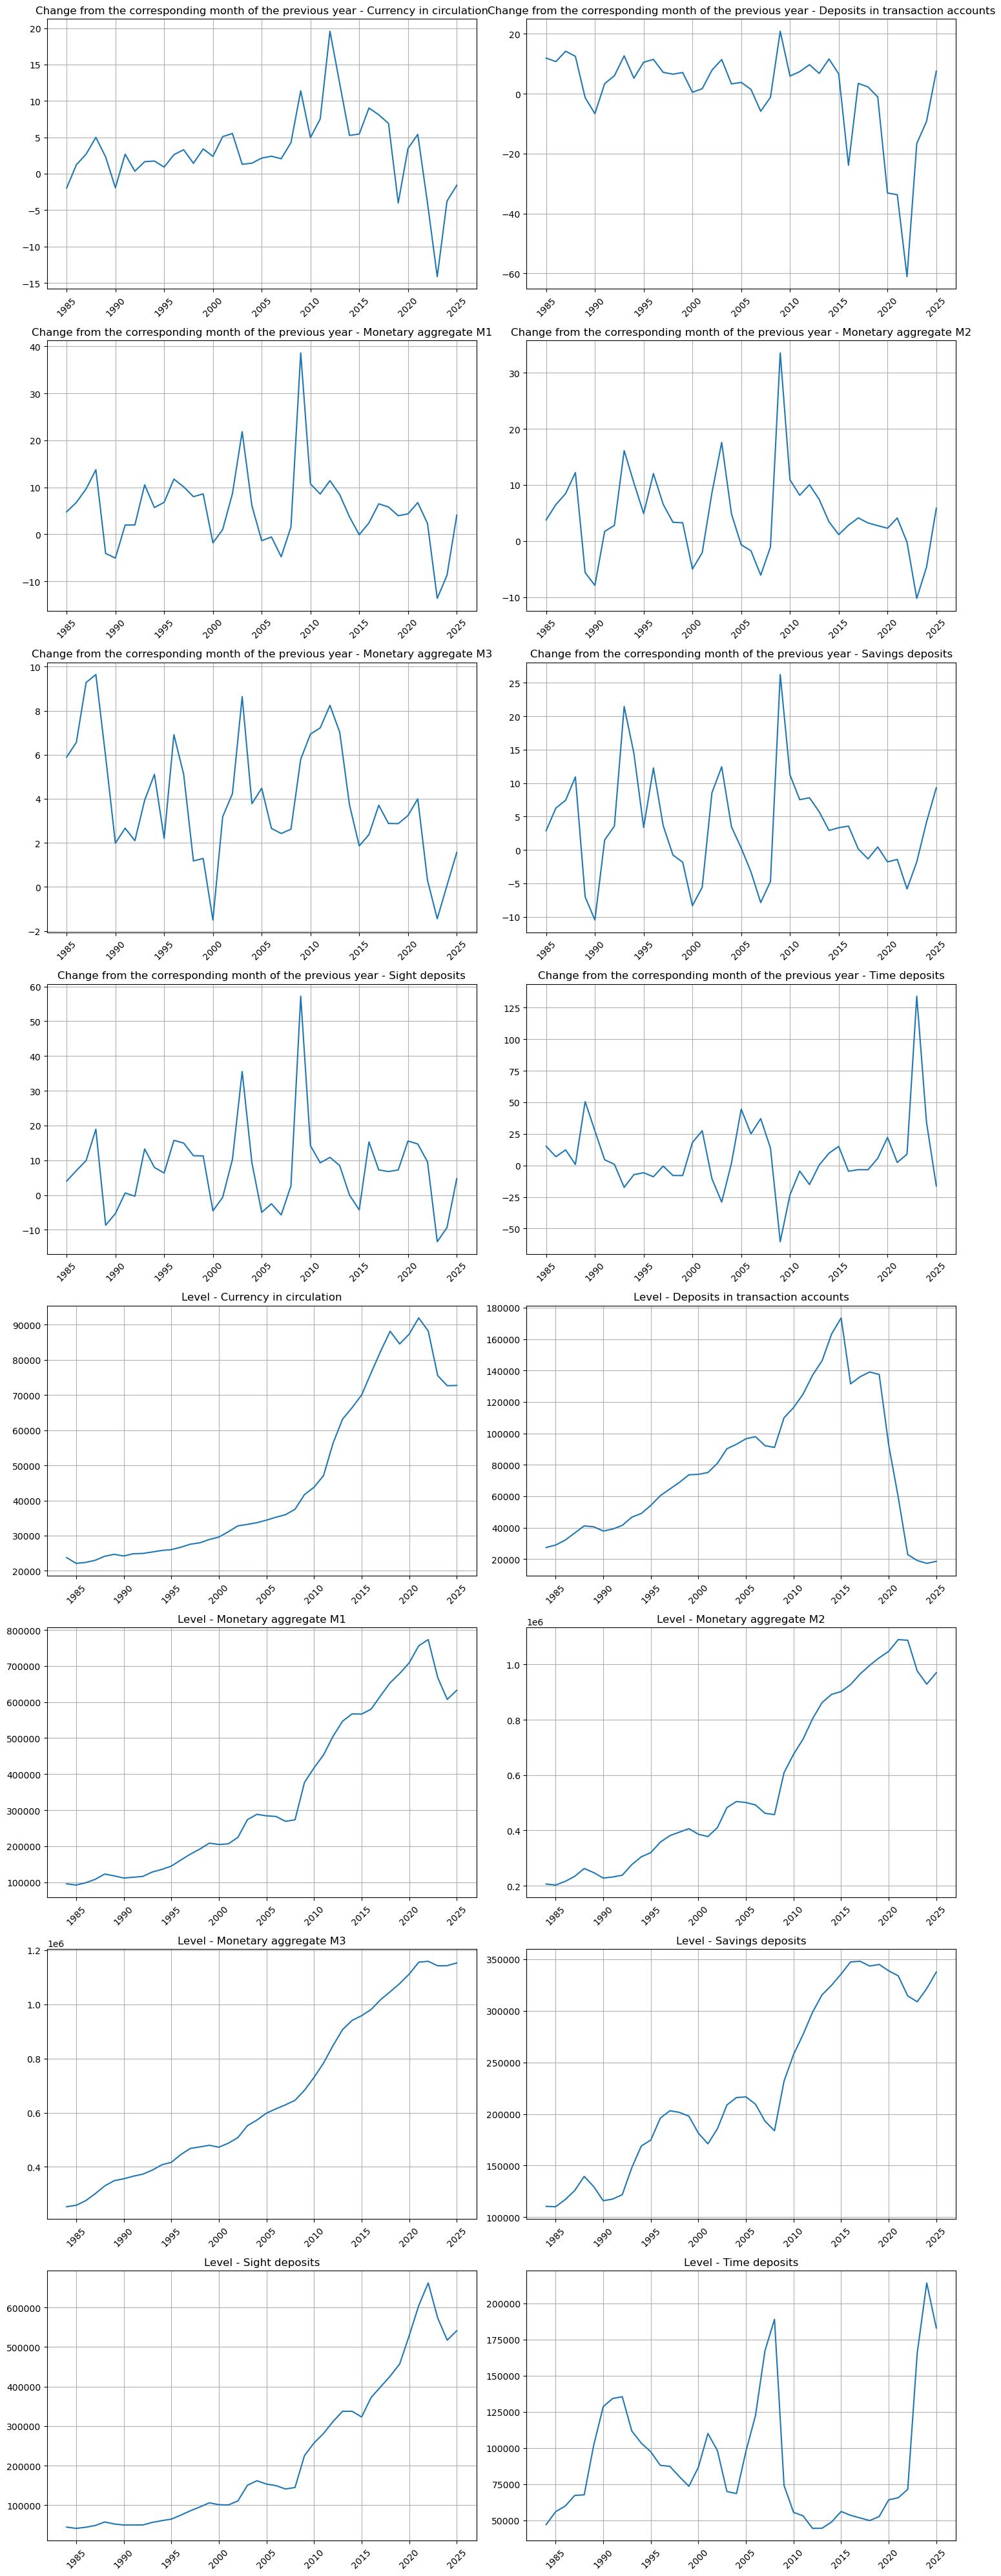

In [24]:
from visualization_function import plot_all_columns

plot_all_columns(yearly_monetary_aggregate_df)

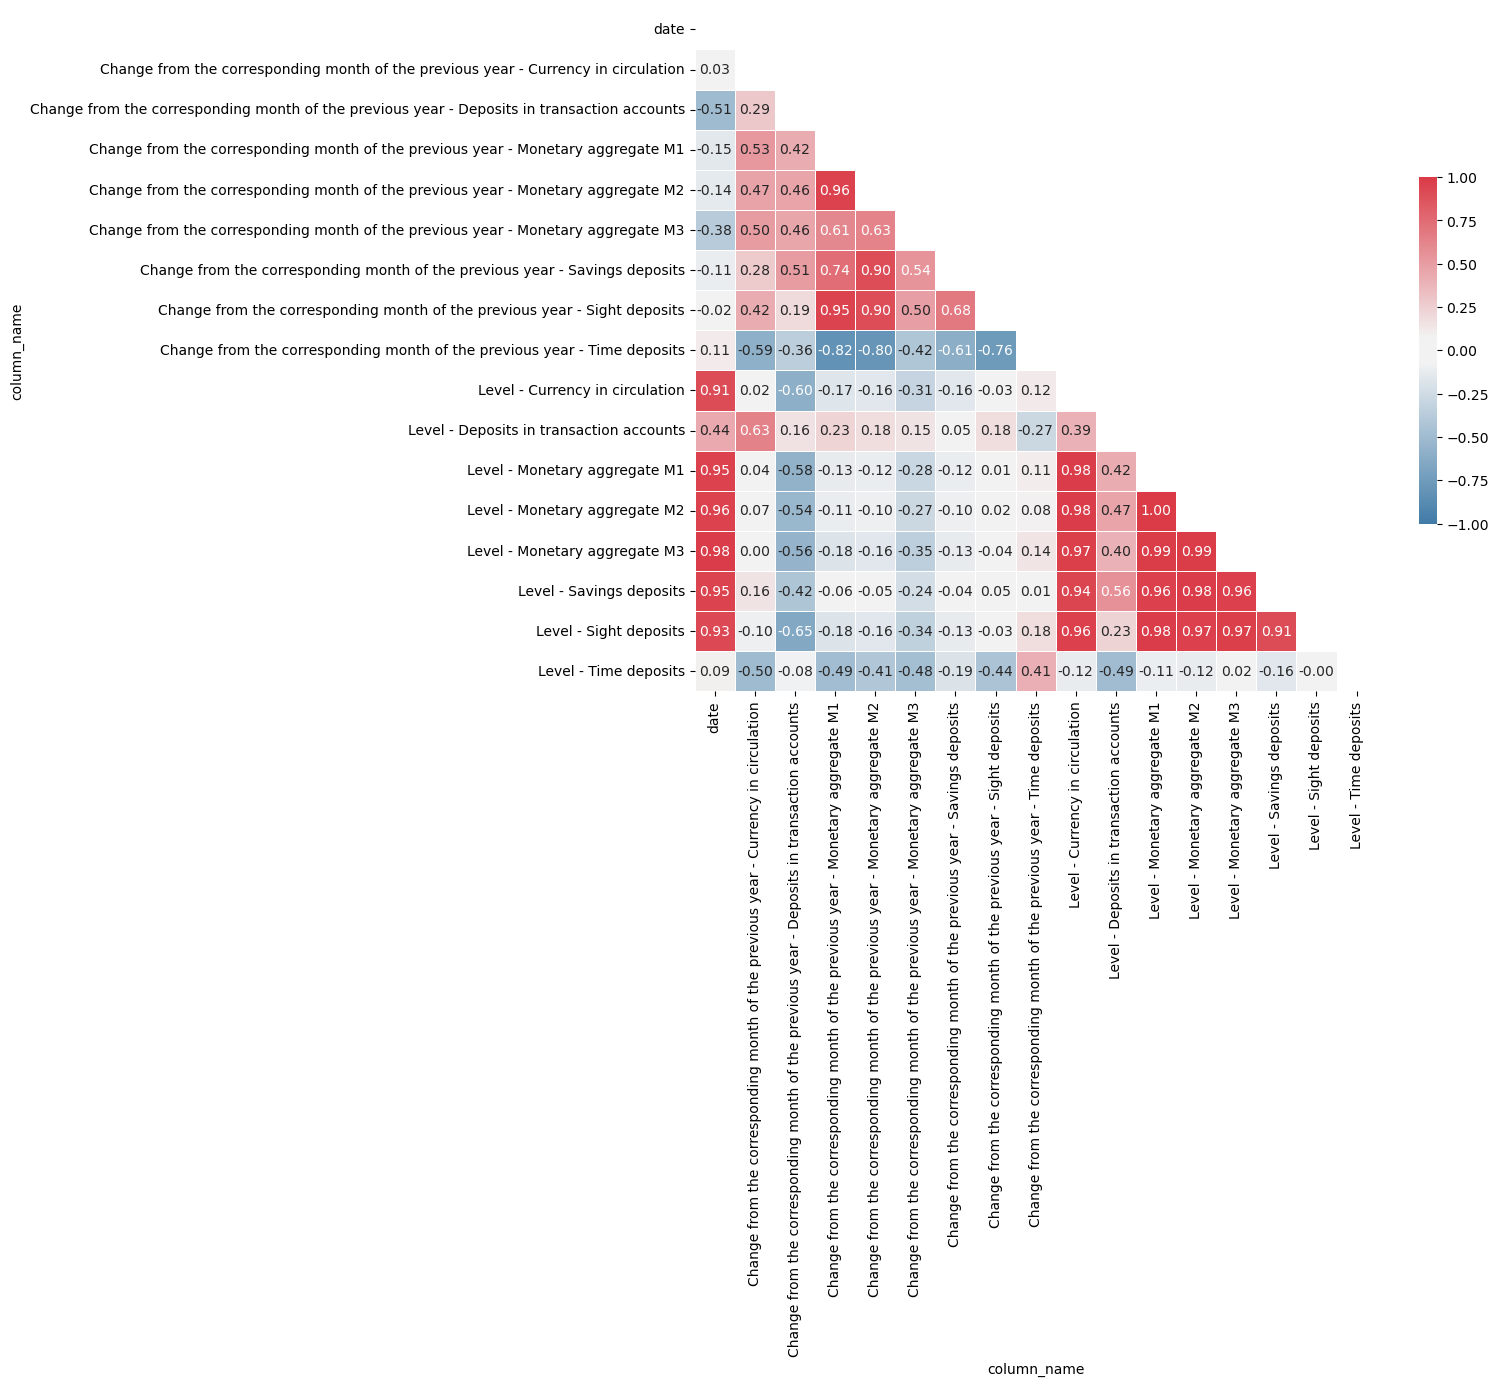

In [25]:
from visualization_function import plot_correlation_heatmap

plot_correlation_heatmap(yearly_monetary_aggregate_df)

## Mortage data

In [26]:
from data_processing import get_and_process_mortgage_data

# Process the data
monthly_mortage_df = get_and_process_mortgage_data(url="https://data.snb.ch/api/cube/bakredinausbm/data/json/en")
monthly_mortage_df


date  \
0   1985-06-01   
1   1985-07-01   
2   1985-08-01   
3   1985-09-01   
4   1985-10-01   
..         ...   
470 2024-08-01   
471 2024-09-01   
472 2024-10-01   
473 2024-11-01   
474 2024-12-01   

     Banks in Switzerland - Total domestic and foreign - Total loans - Utilisation  \
0                                         3.240534e+05                               
1                                         3.221936e+05                               
2                                         3.223212e+05                               
3                                         3.259289e+05                               
4                                         3.258340e+05                               
..                                                 ...                               
470                                       1.546428e+06                               
471                                       1.551801e+06                               
472                                       1.556721e+06                               
473                                       1.559916e+06                               
474                                       1.567763e+06                               

     Banks in Switzerland - Total domestic and foreign - Total loans - Credit lines  \
0                                         4.247455e+05                                
1                                         4.289201e+05                                
2                                         4.292811e+05                                
3                                         4.388349e+05                                
4                                         4.417075e+05                                
..                                                 ...                                
470                                       2.127347e+06                                
471                                       2.135815e+06                                
472                                       2.143698e+06                                
473                                       2.153503e+06                                
474                                       2.158644e+06                                

     Banks in Switzerland - Total domestic and foreign - Mortgage loans - Utilisation  \
0                                         1.794905e+05                                  
1                                         1.811207e+05                                  
2                                         1.836626e+05                                  
3                                         1.849059e+05                                  
4                                         1.863949e+05                                  
..                                                 ...                                  
470                                       1.205704e+06                                  
471                                       1.207592e+06                                  
472                                       1.211297e+06                                  
473                                       1.214316e+06                                  
474                                       1.216730e+06                                  

     Banks in Switzerland - Total domestic and foreign - Other loans - Total - Utilisation  \
0                                        145314.759085                                       
1                                        141752.186144                                       
2                                        139274.012514                                       
3                                        141663.281639                                       
4                                        140039.954241                                       
..                                                 ...                            

In [27]:
from data_processing import group_data_by_year

yearly_mortgage_df = group_data_by_year(monthly_mortage_df)
yearly_mortgage_df

date  \
0  1985-01-01   
1  1986-01-01   
2  1987-01-01   
3  1988-01-01   
4  1989-01-01   
5  1990-01-01   
6  1991-01-01   
7  1992-01-01   
8  1993-01-01   
9  1994-01-01   
10 1995-01-01   
11 1996-01-01   
12 1997-01-01   
13 1998-01-01   
14 1999-01-01   
15 2000-01-01   
16 2001-01-01   
17 2002-01-01   
18 2003-01-01   
19 2004-01-01   
20 2005-01-01   
21 2006-01-01   
22 2007-01-01   
23 2008-01-01   
24 2009-01-01   
25 2010-01-01   
26 2011-01-01   
27 2012-01-01   
28 2013-01-01   
29 2014-01-01   
30 2015-01-01   
31 2016-01-01   
32 2017-01-01   
33 2018-01-01   
34 2019-01-01   
35 2020-01-01   
36 2021-01-01   
37 2022-01-01   
38 2023-01-01   
39 2024-01-01   

    Banks in Switzerland - Total domestic and foreign - Total loans - Utilisation  \
0                                        3.264523e+05                               
1                                        3.460229e+05                               
2                                        3.753198e+05                               
3                                        4.173933e+05                               
4                                        4.768238e+05                               
5                                        5.262938e+05                               
6                                        5.619278e+05                               
7                                        5.821800e+05                               
8                                        5.954091e+05                               
9                                        6.087834e+05                               
10                                       6.144655e+05                               
11                                       6.262035e+05                               
12                                       6.409612e+05                               
13                                       6.494631e+05                               
14                                       6.793298e+05                               
15                                       7.038352e+05                               
16                                       7.158058e+05                               
17                                       7.136156e+05                               
18                                       7.073172e+05                               
19                                       7.337752e+05                               
20                                       7.783018e+05                               
21                                       8.428816e+05                               
22                                       9.510462e+05                               
23                                       1.007109e+06                               
24                                       9.844298e+05                               
25                                       1.010848e+06                               
26                                       1.033416e+06                               
27                                       1.079750e+06                               
28                                       1.144262e+06                               
29                                       1.204706e+06                               
30                                       1.225848e+06                               
31                                       1.256652e+06                               
32                                       1.306627e+06                               
33                                       1.347754e+06                               
34                                       1.381642e+06                               
35                                       1.428423e+06                               
36                                       1.493693e+06                               
37                                       1.538040e+06                            

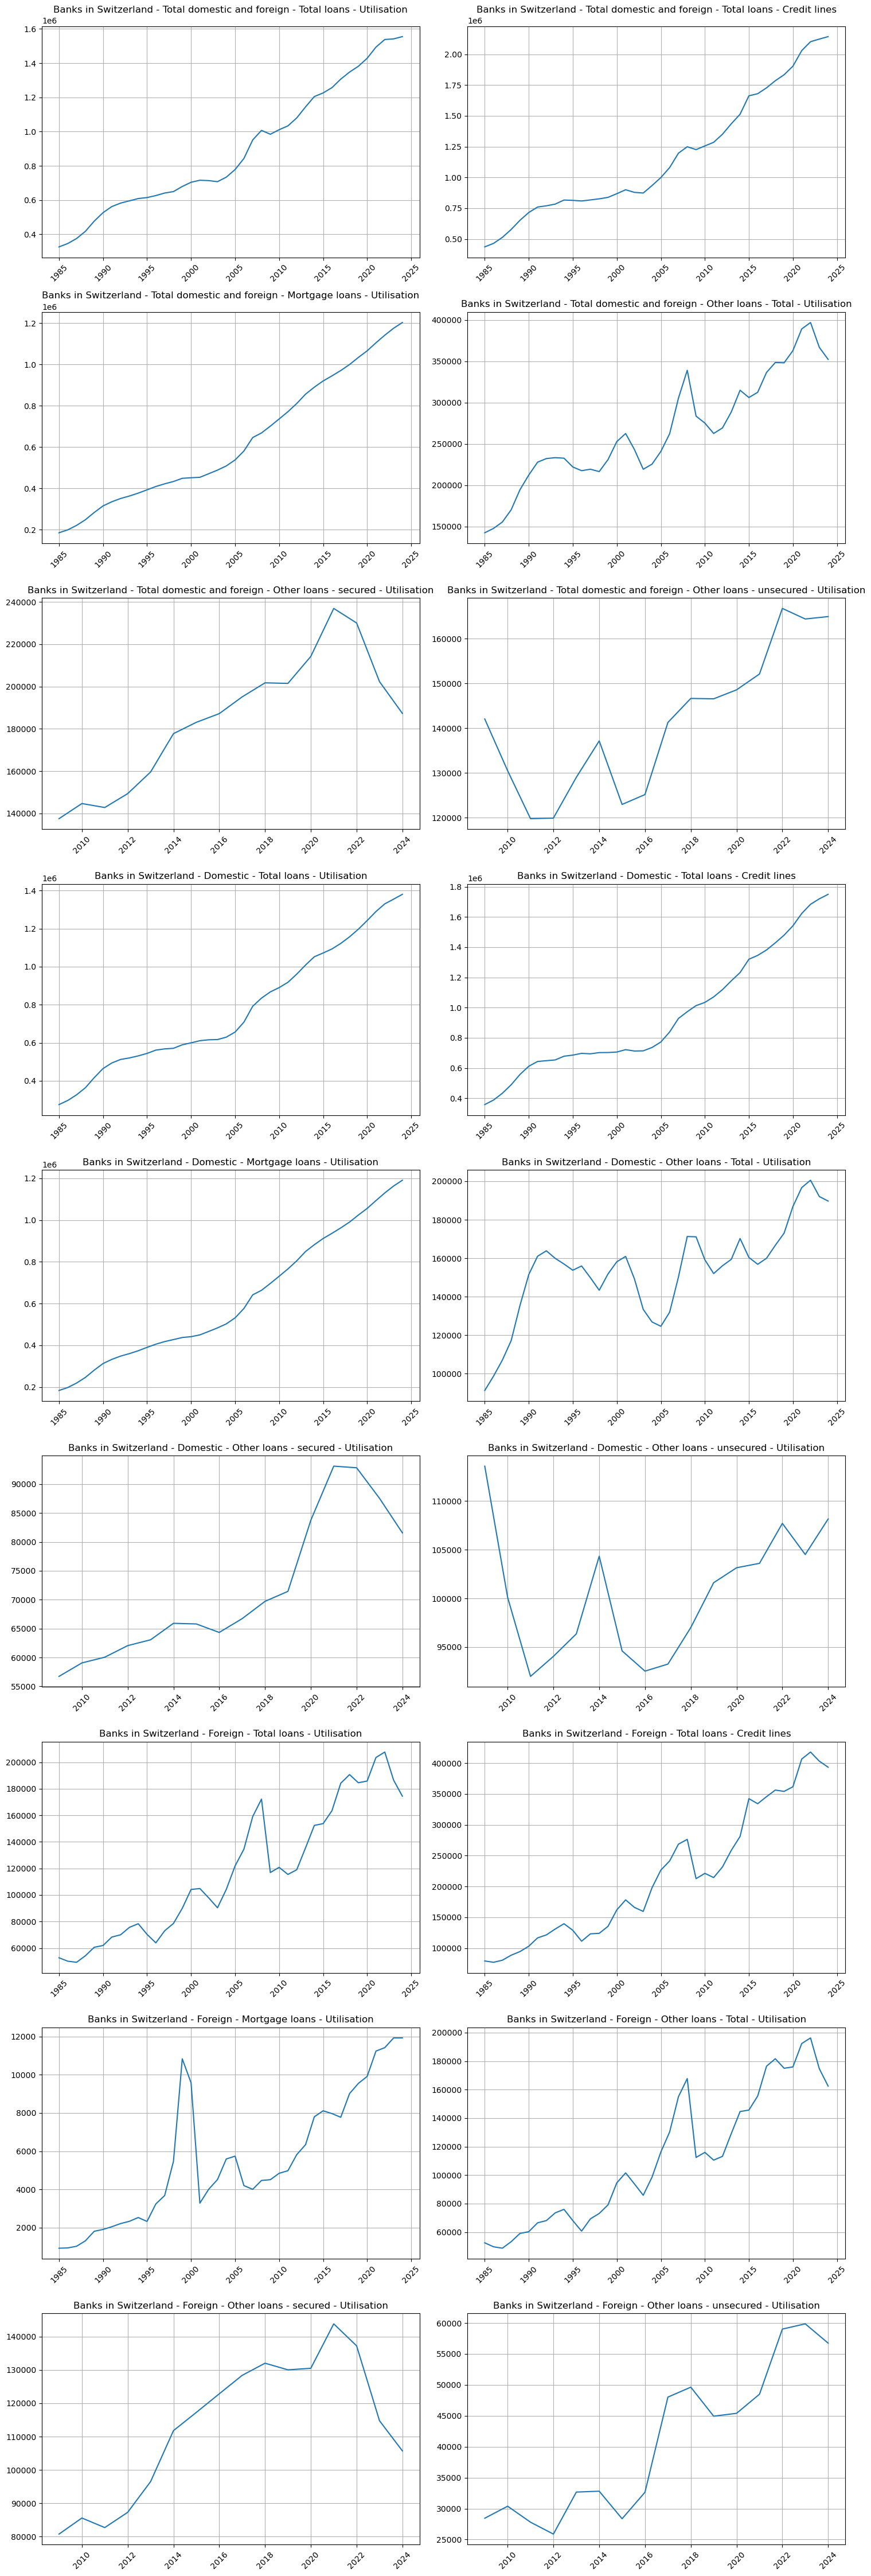

In [28]:
from visualization_function import plot_all_columns

plot_all_columns(yearly_mortgage_df)

## GDP

In [29]:
from data_processing import get_and_process_snb_data_two_header_levels

q_gdp_df = get_and_process_snb_data_two_header_levels(url="https://data.snb.ch/api/cube/gdpgnp/data/json/en")
q_gdp_df = q_gdp_df[['date', 'Value, in CHF millions - Gross domestic product']]
q_gdp_df

column_name       date  Value, in CHF millions - Gross domestic product
0           1990-01-01                                     90520.631548
1           1990-04-01                                     92079.420158
2           1990-07-01                                     92907.933322
3           1990-10-01                                     93884.236177
4           1991-01-01                                     95679.562423
..                 ...                                              ...
134         2023-07-01                                    201010.386251
135         2023-10-01                                    201837.783735
136         2024-01-01                                    204620.821290
137         2024-04-01                                    205977.944603
138         2024-07-01                                    207180.063104

[139 rows x 2 columns]

In [30]:
from data_processing import group_data_by_year_sum

yearly_gdp_df = group_data_by_year_sum(q_gdp_df)
yearly_gdp_df = yearly_gdp_df[yearly_gdp_df['date'].dt.year != 2024]
yearly_gdp_df

column_name       date  Value, in CHF millions - Gross domestic product
0           1990-01-01                                     369392.22121
1           1991-01-01                                     385747.93824
2           1992-01-01                                     393408.66854
3           1993-01-01                                     401920.59908
4           1994-01-01                                     412011.52121
5           1995-01-01                                     417529.12955
6           1996-01-01                                     420537.73860
7           1997-01-01                                     427876.24593
8           1998-01-01                                     439633.46241
9           1999-01-01                                     447010.87261
10          2000-01-01                                     471707.25335
11          2001-01-01                                     483978.42518
12          2002-01-01                                     482509.49014
13          2003-01-01                                     487659.86504
14          2004-01-01                                     501701.46634
15          2005-01-01                                     520819.42618
16          2006-01-01                                     554078.31005
17          2007-01-01                                     589474.12521
18          2008-01-01                                     614039.78268
19          2009-01-01                                     602688.11551
20          2010-01-01                                     624008.73541
21          2011-01-01                                     635722.26511
22          2012-01-01                                     643772.74615
23          2013-01-01                                     655083.16100
24          2014-01-01                                     665700.17970
25          2015-01-01                                     667701.00018
26          2016-01-01                                     677729.68558
27          2017-01-01                                     684903.19266
28          2018-01-01                                     709864.55021
29          2019-01-01                                     717322.81913
30          2020-01-01                                     696040.50482
31          2021-01-01                                     744508.23823
32          2022-01-01                                     791105.94414
33          2023-01-01                                     804039.10442

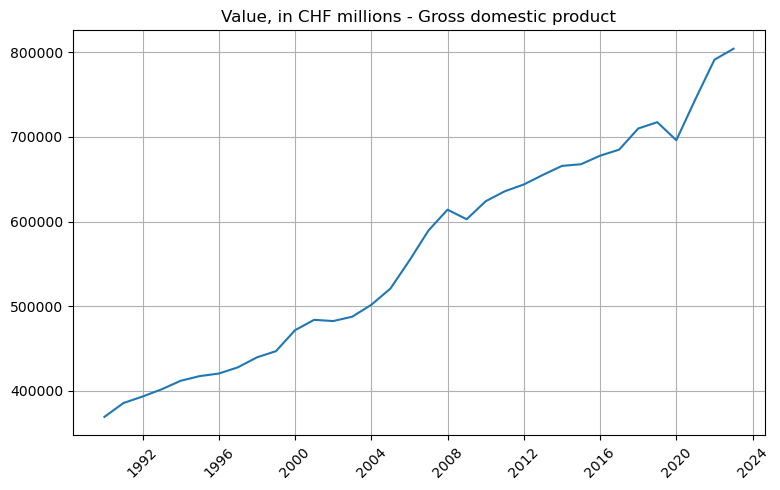

In [31]:
from visualization_function import plot_all_columns

plot_all_columns(yearly_gdp_df)

## Population size

In [32]:
from data_processing import get_swiss_population_data

population_df = get_swiss_population_data()
population_df

date  population
0  1960-01-01   5327827.0
1  1961-01-01   5434294.0
2  1962-01-01   5573815.0
3  1963-01-01   5694247.0
4  1964-01-01   5789228.0
..        ...         ...
59 2019-01-01   8575280.0
60 2020-01-01   8638167.0
61 2021-01-01   8704546.0
62 2022-01-01   8777088.0
63 2023-01-01   8888093.0

[64 rows x 2 columns]

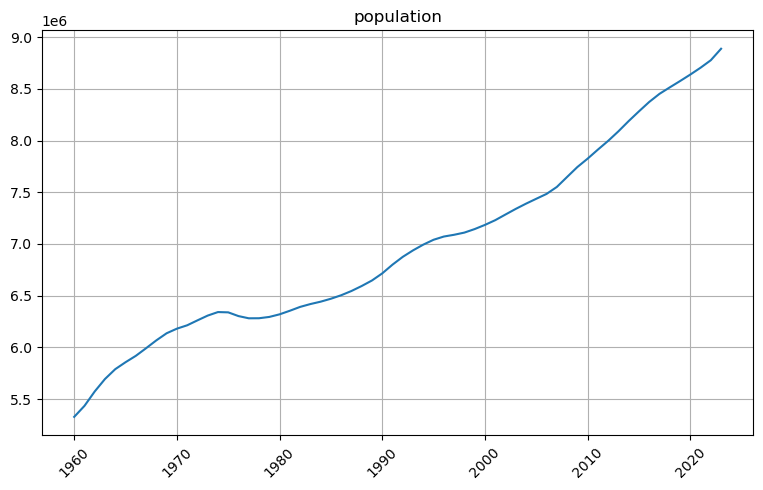

In [33]:
from visualization_function import plot_all_columns

plot_all_columns(population_df)

## Get inflation data

In [12]:
from data_processing import get_and_process_snb_data, group_data_by_year

monthly_inflation_df = get_and_process_snb_data(url="https://data.snb.ch/api/cube/plkoprinfla/data/json/en")
monthly_inflation_df = monthly_inflation_df[['date', 'SFSO - Inflation according to the national consumer price index']]
inflation_df = group_data_by_year(monthly_inflation_df)
inflation_df

date  SFSO - Inflation according to the national consumer price index
0  1983-01-01                                                          2.10000
1  1984-01-01                                                          2.94167
2  1985-01-01                                                          3.43333
3  1986-01-01                                                          0.75000
4  1987-01-01                                                          1.45833
5  1988-01-01                                                          1.88333
6  1989-01-01                                                          3.15000
7  1990-01-01                                                          5.41667
8  1991-01-01                                                          5.87500
9  1992-01-01                                                          4.05833
10 1993-01-01                                                          3.29167
11 1994-01-01                                                          0.85000
12 1995-01-01                                                          1.80000
13 1996-01-01                                                          0.80833
14 1997-01-01                                                          0.51667
15 1998-01-01                                                          0.01667
16 1999-01-01                                                          0.80833
17 2000-01-01                                                          1.55000
18 2001-01-01                                                          1.00833
19 2002-01-01                                                          0.63333
20 2003-01-01                                                          0.62500
21 2004-01-01                                                          0.80000
22 2005-01-01                                                          1.17500
23 2006-01-01                                                          1.07500
24 2007-01-01                                                          0.73333
25 2008-01-01                                                          2.43333
26 2009-01-01                                                         -0.48333
27 2010-01-01                                                          0.68333
28 2011-01-01                                                          0.25000
29 2012-01-01                                                         -0.70000
30 2013-01-01                                                         -0.21667
31 2014-01-01                                                         -0.01667
32 2015-01-01                                                         -1.14167
33 2016-01-01                                                         -0.43333
34 2017-01-01                                                          0.53333
35 2018-01-01                                                          0.92500
36 2019-01-01                                                          0.35833
37 2020-01-01                                                         -0.73333
38 2021-01-01                                                          0.58333
39 2022-01-01                                                          2.83333
40 2023-01-01                                                          2.15000
41 2024-01-01                                                          1.05833
42 2025-01-01                                                          0.40000

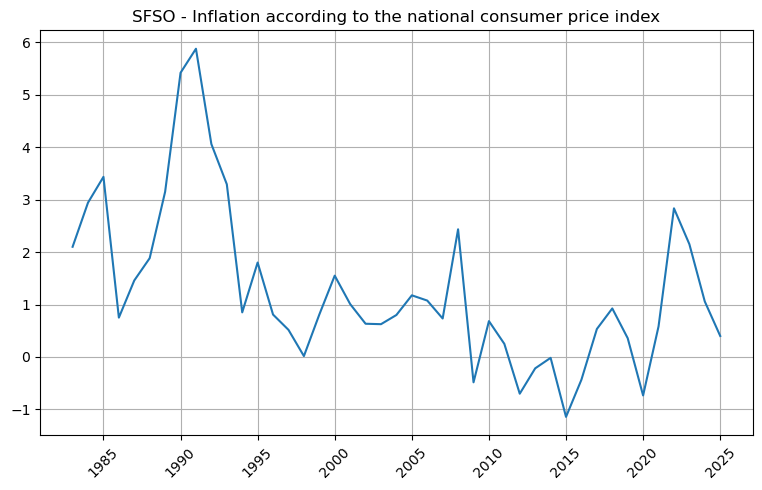

In [13]:
from visualization_function import plot_all_columns

plot_all_columns(inflation_df)

# Getting and Joining All Data

In [1]:
import pandas as pd

from data_processing import *

pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Auto-detect display width
pd.set_option('display.max_colwidth', None)  # Show full content of each column

def get_and_merge_all_data():
    """
    Fetches all data from different sources and merges them on the date column.
    Returns a single dataframe with all variables joined.
    """
    # Get Housing Data
    dfs = get_clean_housing_data()
    housing_df = dfs['housing_df']
    
    # Get Demographics Data
    raw_demographics_df = get_demographics_data()
    demographics_df = long_to_wide_demographics(raw_demographics_df)
    
    # Get Interest Rates Data
    monthly_interest_rates_df = get_and_process_snb_data(url="https://data.snb.ch/api/cube/zimoma/data/json/en")
    interest_rates_df = group_data_by_year(monthly_interest_rates_df)
    
    # Get Monetary Base Data
    monthly_monetary_base_df = get_and_process_snb_data(url="https://data.snb.ch/api/cube/snbmoba/data/json/en")
    monetary_base_df = group_data_by_year(monthly_monetary_base_df)
    
    # Get Monetary Aggregates Data
    monthly_monetary_aggregate_df = get_and_process_snb_data_two_header_levels(url="https://data.snb.ch/api/cube/snbmonagg/data/json/en")
    monetary_aggregate_df = group_data_by_year(monthly_monetary_aggregate_df)
    
    # Get Mortgage Data
    monthly_mortage_df = get_and_process_mortgage_data(url="https://data.snb.ch/api/cube/bakredinausbm/data/json/en")
    mortgage_df = group_data_by_year(monthly_mortage_df)
    
    # Get GDP Data
    q_gdp_df = get_and_process_snb_data_two_header_levels(url="https://data.snb.ch/api/cube/gdpgnp/data/json/en")
    q_gdp_df = q_gdp_df[['date', 'Value, in CHF millions - Gross domestic product']]
    gdp_df = group_data_by_year_sum(q_gdp_df)
    gdp_df = gdp_df[gdp_df['date'].dt.year != 2024]
    
    # Get Population Data
    population_df = get_swiss_population_data()
    
    # Get inflation Data
    monthly_inflation_df = get_and_process_snb_data(url="https://data.snb.ch/api/cube/plkoprinfla/data/json/en")
    monthly_inflation_df = monthly_inflation_df[['date', 'SFSO - Inflation according to the national consumer price index']]
    inflation_df = group_data_by_year(monthly_inflation_df)
    
    # Merge all dataframes on date
    merged_df = housing_df.copy()
    dataframes = [
        demographics_df,
        interest_rates_df, 
        monetary_base_df,
        monetary_aggregate_df,
        mortgage_df,
        gdp_df,
        population_df,
        inflation_df
    ]
    
    for df in dataframes:
        merged_df = merged_df.merge(df, on='date', how='outer')
    
    return merged_df

# Get merged dataframe with all variables
merged_data_df = get_and_merge_all_data()

# Joining data

In [2]:
filtered_df = merged_data_df[(merged_data_df['date'] > '1984-01-01') & (merged_data_df['date'] < '2025-01-01')]  # This is when most data begins
filtered_df

date               property_type  asking_price  transaction_price  \
139 1985-01-01  Privately owned apartments     83.912580          86.544761   
140 1985-01-01        Single-family houses     87.829031          78.783493   
141 1986-01-01  Privately owned apartments     88.455781          89.838592   
142 1986-01-01        Single-family houses     93.094012          80.467450   
143 1987-01-01  Privately owned apartments     96.106603          92.913925   
144 1987-01-01        Single-family houses     99.369015          83.247602   
145 1988-01-01  Privately owned apartments    106.532142         100.460406   
146 1988-01-01        Single-family houses    114.249554          87.395326   
147 1989-01-01  Privately owned apartments    117.153140         108.071435   
148 1989-01-01        Single-family houses    128.824078          96.118802   
149 1990-01-01  Privately owned apartments    122.837172         111.508952   
150 1990-01-01        Single-family houses    128.466620         101.977574   
151 1991-01-01  Privately owned apartments    121.845429         113.041170   
152 1991-01-01        Single-family houses    126.345437         103.986745   
153 1992-01-01  Privately owned apartments    116.643640         113.577342   
154 1992-01-01        Single-family houses    120.784772         102.938816   
155 1993-01-01  Privately owned apartments    111.889770         112.631568   
156 1993-01-01        Single-family houses    114.538126         101.464287   
157 1994-01-01  Privately owned apartments    111.525066         111.752704   
158 1994-01-01        Single-family houses    114.449948         101.107869   
159 1995-01-01  Privately owned apartments    108.310949         109.565882   
160 1995-01-01        Single-family houses    109.992147         101.155977   
161 1996-01-01         Apartment buildings           NaN          81.266481   
162 1996-01-01  Privately owned apartments    104.501115         107.472494   
163 1996-01-01        Single-family houses    103.699882          98.155034   
164 1997-01-01         Apartment buildings           NaN          77.056807   
165 1997-01-01  Privately owned apartments     99.755442         104.101536   
166 1997-01-01        Single-family houses    100.093091          96.439222   
167 1998-01-01         Apartment buildings           NaN          75.768477   
168 1998-01-01  Privately owned apartments     98.408393         102.151566   
169 1998-01-01        Single-family houses     99.228959          96.085323   
170 1999-01-01         Apartment buildings           NaN          77.663301   
171 1999-01-01  Privately owned apartments     98.533462          99.713424   
172 1999-01-01        Single-family houses     99.081640          97.166493   
173 2000-01-01         Apartment buildings           NaN          76.235689   
174 2000-01-01  Privately owned apartments    100.000000         100.000000   
175 2000-01-01        Single-family houses    100.000000         100.000000   
176 2001-01-01         Apartment buildings           NaN          76.777046   
177 2001-01-01  Privately owned apartments    104.297290         101.503854   
178 2001-01-01        Single-family houses    101.927285         102.556348   
179 2002-01-01         Apartment buildings           NaN          75.775923   
180 2002-01-01  Privately owned apartments    112.400787         102.720786   
181 2002-01-01        Single-family houses    106.646918         101.465418   
182 2003-01-01         Apartment buildings           NaN          77.171776   
183 2003-01-01  Privately owned apartments    119.483796         105.507104   
184 2003-01-01        Single-family houses    109.827395         103.092880   
185 2004-01-01         Apartment buildings           NaN          80.498467   
186 2004-01-01  Privately owned apartments    122.515645         109.607646   
187 2004-01-01        Single-family houses    112.424393         104.809739   
188 2005-01-01         Apartment buildings           NaN    

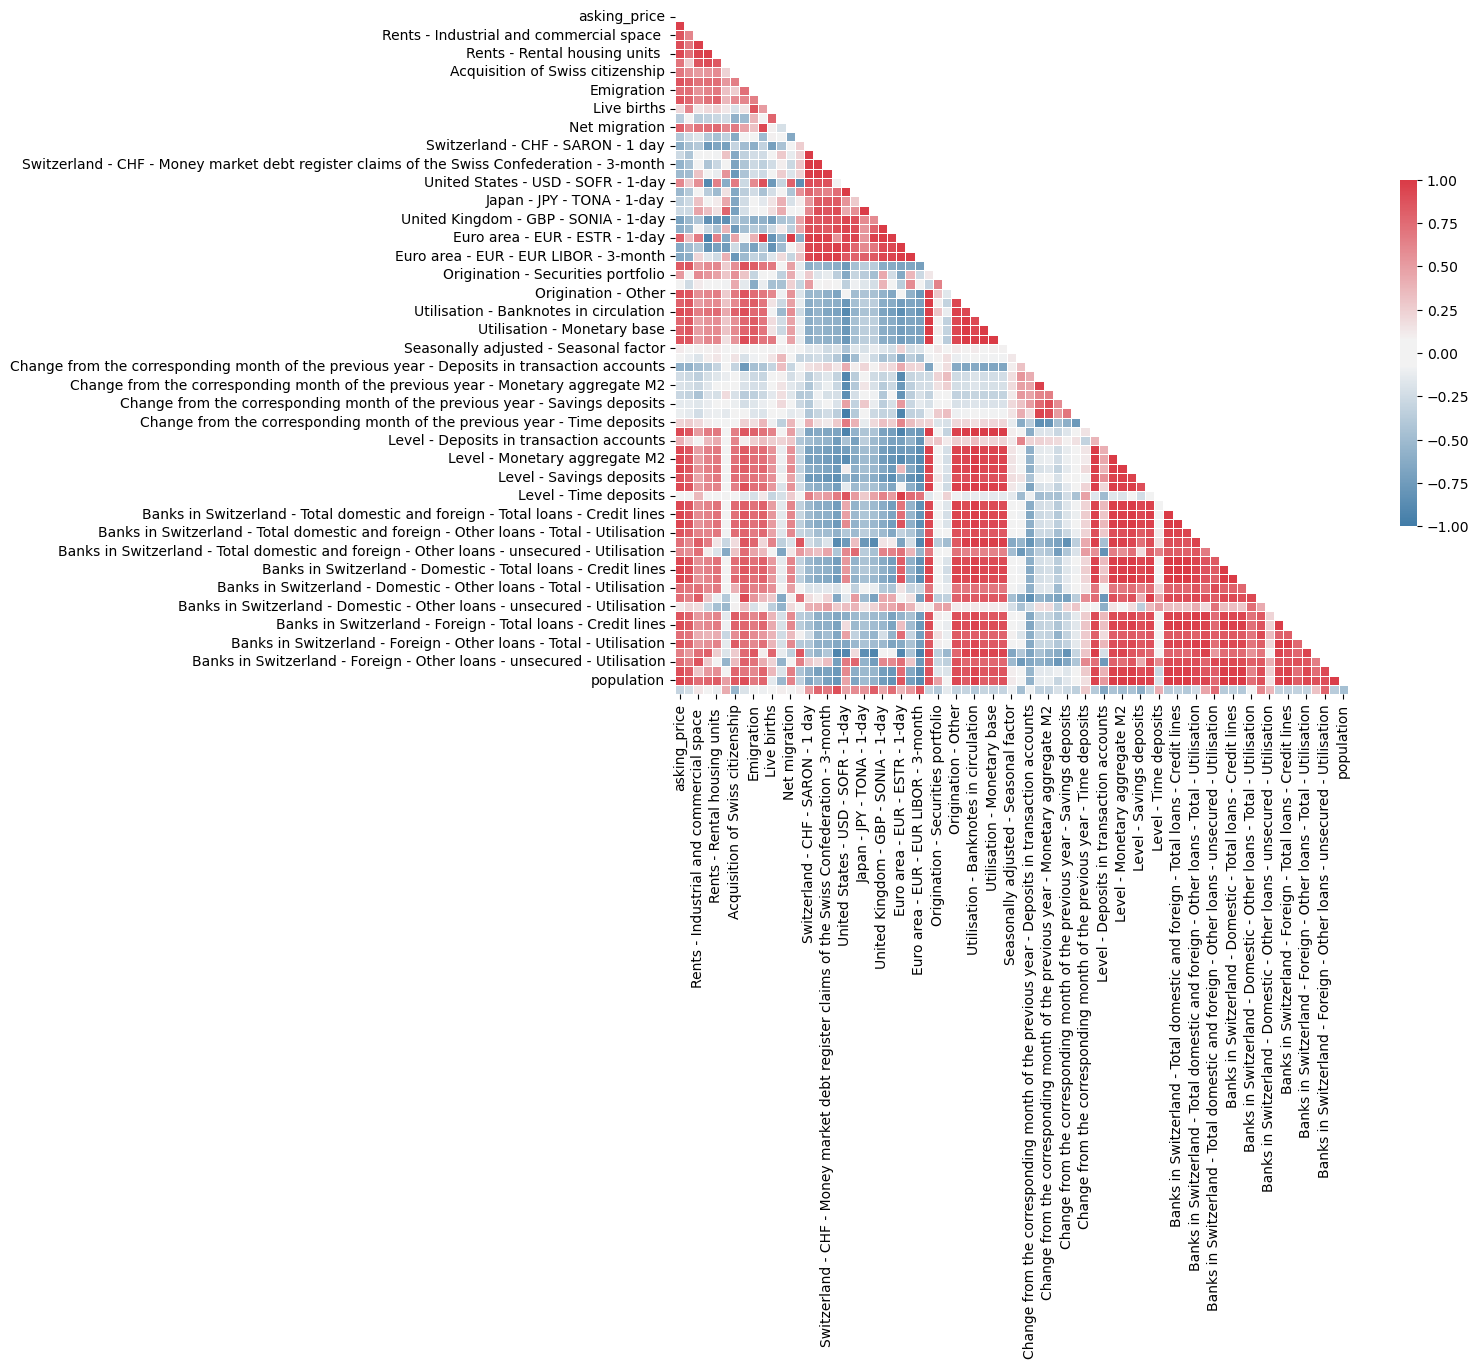

<Axes: >

In [5]:
from visualization_function import plot_correlation_heatmap

plot_correlation_heatmap(merged_data_df, annot=False, figsize=(11,9))

In [14]:
# Removing some uneccesary collumm based on intuition and theory
# - Changes because I already have levels
# - Disagregated morgage data because I will include the total
# - Seasonal and statistical adjustements because they may add noise
# - Non CH interest rates
# - Net measures of immi/emigtation and births/death because I will include Natural change and net migration
# - Short term interest rates: keeping Switzerland - CHF - Call money rate (Tomorrow next) - 1 day because more data availability

lean_merged_data_df = filtered_df.drop(columns=[
    'Change from the corresponding month of the previous year - Currency in circulation',
    'Change from the corresponding month of the previous year - Deposits in transaction accounts',
    'Change from the corresponding month of the previous year - Monetary aggregate M1',
    'Change from the corresponding month of the previous year - Monetary aggregate M2',
    'Change from the corresponding month of the previous year - Monetary aggregate M3',
    'Change from the corresponding month of the previous year - Savings deposits',
    'Change from the corresponding month of the previous year - Sight deposits',
    'Change from the corresponding month of the previous year - Time deposits',
    'Banks in Switzerland - Domestic - Total loans - Utilisation',
    'Banks in Switzerland - Domestic - Total loans - Credit lines',
    'Banks in Switzerland - Domestic - Mortgage loans - Utilisation',
    'Banks in Switzerland - Domestic - Other loans - Total - Utilisation',
    'Banks in Switzerland - Domestic - Other loans - secured - Utilisation',
    'Banks in Switzerland - Domestic - Other loans - unsecured - Utilisation',
    'Banks in Switzerland - Foreign - Total loans - Utilisation',
    'Banks in Switzerland - Foreign - Total loans - Credit lines',
    'Banks in Switzerland - Foreign - Mortgage loans - Utilisation',
    'Banks in Switzerland - Foreign - Other loans - Total - Utilisation',
    'Banks in Switzerland - Foreign - Other loans - secured - Utilisation',
    'Banks in Switzerland - Foreign - Other loans - unsecured - Utilisation',
    'Statistical adjustments',
    'Seasonally adjusted - Seasonal factor',
    'United States - USD - SOFR - 1-day',
    'United States - USD - USD LIBOR - 3-month',
    'Japan - JPY - TONA - 1-day', 
    'Japan - JPY - JPY LIBOR - 3-month',
    'United Kingdom - GBP - SONIA - 1-day',
    'United Kingdom - GBP - GBP LIBOR - 3-month',
    'Euro area - EUR - ESTR - 1-day', 'Euro area - EUR - EURIBOR - 3-month',
    'Euro area - EUR - EUR LIBOR - 3-month',
    'Deaths', 
    'Emigration',
    'Immigration', 
    'Live births',
    'Switzerland - CHF - SARON - 1 day',
    'Switzerland - CHF - Money market debt register claims of the Swiss Confederation - 3-month',
    'Switzerland - CHF - CHF LIBOR - 3-month',
    ])


In [15]:
lean_merged_data_df

date               property_type  asking_price  transaction_price  \
139 1985-01-01  Privately owned apartments     83.912580          86.544761   
140 1985-01-01        Single-family houses     87.829031          78.783493   
141 1986-01-01  Privately owned apartments     88.455781          89.838592   
142 1986-01-01        Single-family houses     93.094012          80.467450   
143 1987-01-01  Privately owned apartments     96.106603          92.913925   
144 1987-01-01        Single-family houses     99.369015          83.247602   
145 1988-01-01  Privately owned apartments    106.532142         100.460406   
146 1988-01-01        Single-family houses    114.249554          87.395326   
147 1989-01-01  Privately owned apartments    117.153140         108.071435   
148 1989-01-01        Single-family houses    128.824078          96.118802   
149 1990-01-01  Privately owned apartments    122.837172         111.508952   
150 1990-01-01        Single-family houses    128.466620         101.977574   
151 1991-01-01  Privately owned apartments    121.845429         113.041170   
152 1991-01-01        Single-family houses    126.345437         103.986745   
153 1992-01-01  Privately owned apartments    116.643640         113.577342   
154 1992-01-01        Single-family houses    120.784772         102.938816   
155 1993-01-01  Privately owned apartments    111.889770         112.631568   
156 1993-01-01        Single-family houses    114.538126         101.464287   
157 1994-01-01  Privately owned apartments    111.525066         111.752704   
158 1994-01-01        Single-family houses    114.449948         101.107869   
159 1995-01-01  Privately owned apartments    108.310949         109.565882   
160 1995-01-01        Single-family houses    109.992147         101.155977   
161 1996-01-01         Apartment buildings           NaN          81.266481   
162 1996-01-01  Privately owned apartments    104.501115         107.472494   
163 1996-01-01        Single-family houses    103.699882          98.155034   
164 1997-01-01         Apartment buildings           NaN          77.056807   
165 1997-01-01  Privately owned apartments     99.755442         104.101536   
166 1997-01-01        Single-family houses    100.093091          96.439222   
167 1998-01-01         Apartment buildings           NaN          75.768477   
168 1998-01-01  Privately owned apartments     98.408393         102.151566   
169 1998-01-01        Single-family houses     99.228959          96.085323   
170 1999-01-01         Apartment buildings           NaN          77.663301   
171 1999-01-01  Privately owned apartments     98.533462          99.713424   
172 1999-01-01        Single-family houses     99.081640          97.166493   
173 2000-01-01         Apartment buildings           NaN          76.235689   
174 2000-01-01  Privately owned apartments    100.000000         100.000000   
175 2000-01-01        Single-family houses    100.000000         100.000000   
176 2001-01-01         Apartment buildings           NaN          76.777046   
177 2001-01-01  Privately owned apartments    104.297290         101.503854   
178 2001-01-01        Single-family houses    101.927285         102.556348   
179 2002-01-01         Apartment buildings           NaN          75.775923   
180 2002-01-01  Privately owned apartments    112.400787         102.720786   
181 2002-01-01        Single-family houses    106.646918         101.465418   
182 2003-01-01         Apartment buildings           NaN          77.171776   
183 2003-01-01  Privately owned apartments    119.483796         105.507104   
184 2003-01-01        Single-family houses    109.827395         103.092880   
185 2004-01-01         Apartment buildings           NaN          80.498467   
186 2004-01-01  Privately owned apartments    122.515645         109.607646   
187 2004-01-01        Single-family houses    112.424393         104.809739   
188 2005-01-01         Apartment buildings           NaN    

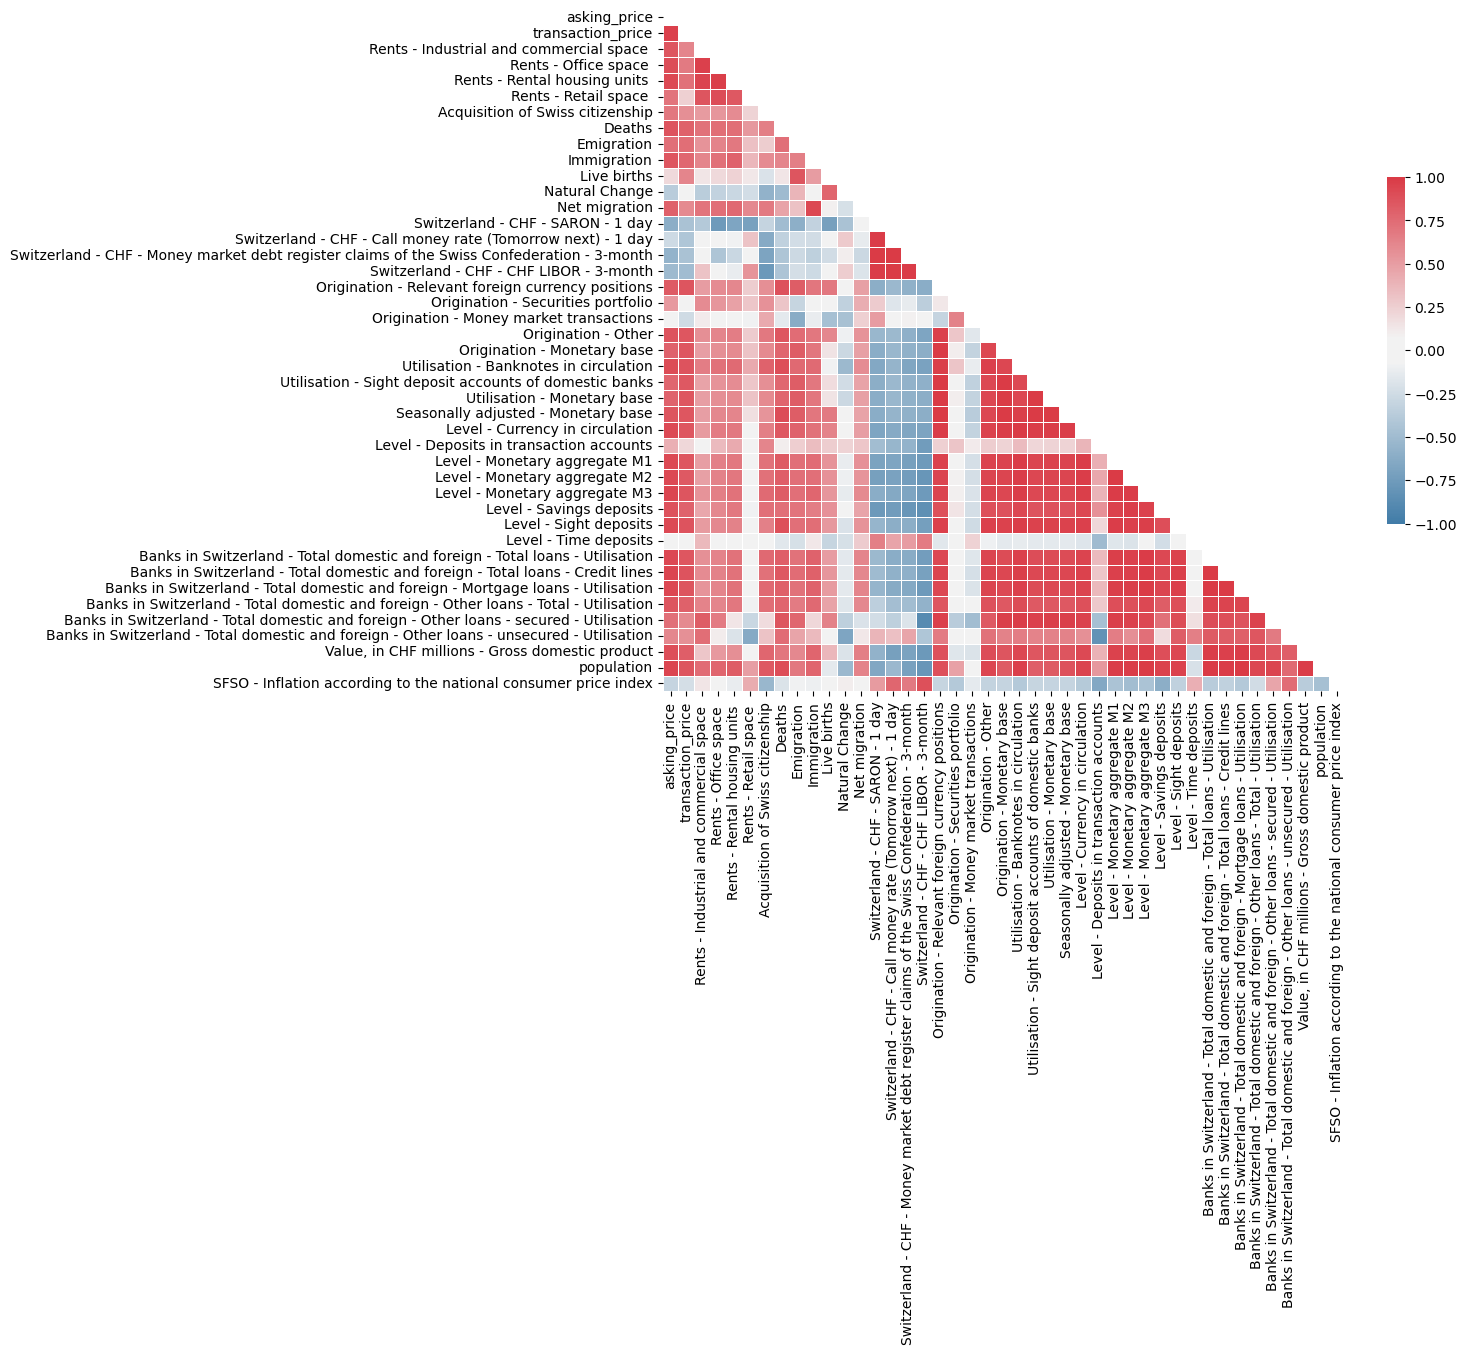

<Axes: >

In [8]:
from visualization_function import plot_correlation_heatmap

plot_correlation_heatmap(lean_merged_data_df, annot=False)

In [9]:
lean_merged_data_df.columns

Index(['date', 'property_type', 'asking_price', 'transaction_price',
       'Rents - Industrial and commercial space ', 'Rents - Office space ',
       'Rents - Rental housing units ', 'Rents - Retail space ',
       'Acquisition of Swiss citizenship', 'Deaths', 'Emigration',
       'Immigration', 'Live births', 'Natural Change', 'Net migration',
       'Switzerland - CHF - SARON - 1 day',
       'Switzerland - CHF - Call money rate (Tomorrow next) - 1 day',
       'Switzerland - CHF - Money market debt register claims of the Swiss Confederation - 3-month',
       'Switzerland - CHF - CHF LIBOR - 3-month',
       'Origination - Relevant foreign currency positions',
       'Origination - Securities portfolio',
       'Origination - Money market transactions', 'Origination - Other',
       'Origination - Monetary base', 'Utilisation - Banknotes in circulation',
       'Utilisation - Sight deposit accounts of domestic banks',
       'Utilisation - Monetary base', 'Seasonally adjusted - Mo